# Mod 4 Project - Gina Durante

## Overview

The Module 4 Project in the Flatiron School Data Science Version 2 Curriculum is meant to provide students with experience in working with time series data--in this case, monthly housing values from 04/01/1996 to 03/01/2018 for over 14,000 ZIP Codes in the U.S.  Skill sets required to complete this project include dataframe manipulation, data cleaning, data visualization, and time series analysis, and other areas (e.g., using github, Jupyter notebooks for data science projects, and writing and posting a blog).  

## Project topic

The project asks the student to identify the 5 "best" ZIP codes for investment, as defined by the student, and develop support for these recommendations to a hypothetical client (e.g., a real estate investment trust).  The student must develop a methodology for evaluating ZIP codes as potential investment targets and support these findings through a technical Jupyter notebook, a non-technical PowerPoint presentation, and a blog post.  


## Methodology, in brief

### Visualization of values by city and/or ZIP code, as well as of predictions of model

While most of my project efforts went towards analyzing ZIP codes in the Sacramento metro region, I did spend quite a bit of time early on developing methods to allow more data exploration--especially visualization.  
* I developed iterative functions to visualize values by city within a metro area and across zip codes within cities in a metro area, using lists and dictionaries to iterate through the geographic areas of interest.  
* Not only did this process improve my dataframe manipulation and visualization skills, it allowed me to see a broader range of geographies and identify interesting patterns in the plots of home values in various geographies.  
* These observations, in turn, suggest some interesting opportunities in other geographies. 

### Consideration of predicted values, worst- and best-case scenarios, and other factors in the selection process

While the predicted returns over the forecast time horizon were of greatest interest, I also took into account the worst-case scenario returns, the best-case scenario returns, the population in the ZIP code, the geographic location of the ZIP code, and personal knowledge of the area to inform my decision-making process.  

## Possible future directions

Several other possible future directions for this work are intriguing:
- While time limitations prevented a broader evaluation of investment opportunities across the country, the functions I developed allow visualizations of broader swaths of the data (e.g., values by metro area, values by city within a metro area, values by zip codes and cities within a metro area).  
  - Creating visualizations at various geographic levels was very useful for identifying patterns that could signify promising investment opportunities.  
  - From this effort, I identified some geographic areas, such as the Dallas-Fort Worth and the Pittsburg metro areas, that could be worthwhile to explore in future efforts.  
- It could be interesting and potentially valuable to do some backtesting on the model to see how well it predicts the last 24 months for which we have data (May 2016 through April 2018).
- Analyzing shorter time frames (e.g., 2013-2018)
- Scaling investment by population size 
- Construct a basket of investments (e.g., $10M, weighted by ZIP population?)


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [6]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sn

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot

import warnings
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

from collections import defaultdict
from collections import OrderedDict

In [7]:
pd.set_option("display.max_rows", 300)

In [8]:
pd.get_option("display.max_rows")

300

In [9]:
df = pd.read_csv('zillow_data.csv')

In [10]:
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

# Step 2: Data Preprocessing

## Convert time data type to datetime format

In [11]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m', errors = 'raise')

In [12]:
get_datetimes(df)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

## Fix problem with ZIP codes beginning with '0'

I have surmised that RegionName is the ZIP code for each entry.  RegionName values with only 4 digits represent ZIP codes that actually begin with '0'.  So that I can work with ZIP codes in the data set, I will need to add that zero onto every 4-digit RegionName value.  Once that's completed, I'll rename this column "ZipCode".  

In [13]:
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [14]:
df.sort_values(by="RegionName").head()

RegionID  RegionName         City State        Metro CountyName  \
5850      58196        1001       Agawam    MA  Springfield    Hampden   
4199      58197        1002      Amherst    MA  Springfield  Hampshire   
11213     58200        1005        Barre    MA    Worcester  Worcester   
6850      58201        1007  Belchertown    MA  Springfield  Hampshire   
14547     58202        1008    Blandford    MA  Springfield    Hampden   

       SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
5850       5851  113100.0  112800.0  112600.0  ...   213900   215700   218200   
4199       4200  161000.0  160100.0  159300.0  ...   333700   334800   336700   
11213     11214  103100.0  103400.0  103600.0  ...   205600   206800   208800   
6850       6851  133400.0  132700.0  132000.0  ...   266100   266300   267000   
14547     14548  117500.0  117300.0  117100.0  ...   202400   202900   205900   

       2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
5850    220100   221100   221700   221700   221700   222700   223600  
4199    338900   340400   342000   344500   347400   350600   353300  
11213   210400   211300   213300   215600   217900   219500   220700  
6850    267500   268000   268100   268100   268800   270000   270600  
14547   208500   207500   205400   204500   206800   210900   214200  

[5 rows x 272 columns]

In [15]:
df['RegionName'] = df.RegionName.astype(str)
df['RegionName'].dtype


dtype('O')

In [16]:
df.rename(columns={'RegionName': 'Zip'}, inplace=True)
df.columns
df.head()

RegionID    Zip      City State              Metro CountyName  SizeRank  \
0     84654  60657   Chicago    IL            Chicago       Cook         1   
1     90668  75070  McKinney    TX  Dallas-Fort Worth     Collin         2   
2     91982  77494      Katy    TX            Houston     Harris         3   
3     84616  60614   Chicago    IL            Chicago       Cook         4   
4     93144  79936   El Paso    TX            El Paso    El Paso         5   

    1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  2017-10  \
0  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800  1009600   
1  235700.0  236900.0  236700.0  ...   308000   310000   312500   314100   
2  210400.0  212200.0  212200.0  ...   321000   320600   320200   320400   
3  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400  1291500   
4   77300.0   77300.0   77300.0  ...   119100   119400   120000   120300   

   2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1013300  1018700  1024400  1030700  1033800  1030600  
1   315000   316600   318100   319600   321100   321800  
2   320800   321200   321200   323000   326900   329900  
3  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [17]:
zips = []

for i in df['Zip']:
    if len(i) < 5:
        i = '0' + i
        zips.append(i)
    else:
        zips.append(i)

zips
df['Zip'] = pd.Series(zips)
df.sort_values(by='Zip').head()
# df.head()

RegionID    Zip         City State        Metro CountyName  SizeRank  \
5850      58196  01001       Agawam    MA  Springfield    Hampden      5851   
4199      58197  01002      Amherst    MA  Springfield  Hampshire      4200   
11213     58200  01005        Barre    MA    Worcester  Worcester     11214   
6850      58201  01007  Belchertown    MA  Springfield  Hampshire      6851   
14547     58202  01008    Blandford    MA  Springfield    Hampden     14548   

        1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  2017-10  \
5850   113100.0  112800.0  112600.0  ...   213900   215700   218200   220100   
4199   161000.0  160100.0  159300.0  ...   333700   334800   336700   338900   
11213  103100.0  103400.0  103600.0  ...   205600   206800   208800   210400   
6850   133400.0  132700.0  132000.0  ...   266100   266300   267000   267500   
14547  117500.0  117300.0  117100.0  ...   202400   202900   205900   208500   

       2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
5850    221100   221700   221700   221700   222700   223600  
4199    340400   342000   344500   347400   350600   353300  
11213   211300   213300   215600   217900   219500   220700  
6850    268000   268100   268100   268800   270000   270600  
14547   207500   205400   204500   206800   210900   214200  

[5 rows x 272 columns]

## Creating dataframes by various groupings and geographies

### Creating US dataframe (df_melt) using melt function

In [18]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID', 'Zip', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=False)
    melted = melted.dropna(subset=['value'])
    return melted   

In [19]:
df_melt = melt_data(df)


In [20]:
df_melt.head()

RegionID    Zip      City State              Metro CountyName  SizeRank  \
0     84654  60657   Chicago    IL            Chicago       Cook         1   
1     90668  75070  McKinney    TX  Dallas-Fort Worth     Collin         2   
2     91982  77494      Katy    TX            Houston     Harris         3   
3     84616  60614   Chicago    IL            Chicago       Cook         4   
4     93144  79936   El Paso    TX            El Paso    El Paso         5   

        time     value  
0 1996-04-01  334200.0  
1 1996-04-01  235700.0  
2 1996-04-01  210400.0  
3 1996-04-01  498100.0  
4 1996-04-01   77300.0

In [21]:
df_melt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744704 entries, 0 to 3901594
Data columns (total 9 columns):
RegionID      int64
Zip           object
City          object
State         object
Metro         object
CountyName    object
SizeRank      int64
time          datetime64[ns]
value         float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 285.7+ MB


In [22]:
df_melt.set_index('time')

RegionID    Zip                 City State              Metro  \
time                                                                        
1996-04-01     84654  60657              Chicago    IL            Chicago   
1996-04-01     90668  75070             McKinney    TX  Dallas-Fort Worth   
1996-04-01     91982  77494                 Katy    TX            Houston   
1996-04-01     84616  60614              Chicago    IL            Chicago   
1996-04-01     93144  79936              El Paso    TX            El Paso   
...              ...    ...                  ...   ...                ...   
2018-04-01     58333  01338             Ashfield    MA    Greenfield Town   
2018-04-01     59107  03293            Woodstock    NH          Claremont   
2018-04-01     75672  40404                Berea    KY           Richmond   
2018-04-01     93733  81225  Mount Crested Butte    CO                NaN   
2018-04-01     95851  89155             Mesquite    NV          Las Vegas   

           CountyName  SizeRank     value  
time                                       
1996-04-01       Cook         1  334200.0  
1996-04-01     Collin         2  235700.0  
1996-04-01     Harris         3  210400.0  
1996-04-01       Cook         4  498100.0  
1996-04-01    El Paso         5   77300.0  
...               ...       ...       ...  
2018-04-01   Franklin     14719  209300.0  
2018-04-01    Grafton     14720  225800.0  
2018-04-01    Madison     14721  133400.0  
2018-04-01   Gunnison     14722  664400.0  
2018-04-01      Clark     14723  357200.0  

[3744704 rows x 8 columns]

In [23]:
## Dropping RegionID:
df_melt.drop('RegionID', axis=1, inplace=True)

In [24]:
df_melt.head()

Zip      City State              Metro CountyName  SizeRank       time  \
0  60657   Chicago    IL            Chicago       Cook         1 1996-04-01   
1  75070  McKinney    TX  Dallas-Fort Worth     Collin         2 1996-04-01   
2  77494      Katy    TX            Houston     Harris         3 1996-04-01   
3  60614   Chicago    IL            Chicago       Cook         4 1996-04-01   
4  79936   El Paso    TX            El Paso    El Paso         5 1996-04-01   

      value  
0  334200.0  
1  235700.0  
2  210400.0  
3  498100.0  
4   77300.0

Dataframe is sorted by SizeRank by default.

In [25]:
df_melt.isna().sum()

Zip                0
City               0
State              0
Metro         236023
CountyName         0
SizeRank           0
time               0
value              0
dtype: int64

In [26]:
df_melt['Metro'].fillna('Missing', inplace=True)
df_melt.isna().sum()

Zip           0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
time          0
value         0
dtype: int64

In [27]:
# Sorting by zip code, then time

df_melt.sort_values(by=['Zip', 'time'])

Zip       City State        Metro         CountyName  SizeRank  \
5850     01001     Agawam    MA  Springfield            Hampden      5851   
20573    01001     Agawam    MA  Springfield            Hampden      5851   
35296    01001     Agawam    MA  Springfield            Hampden      5851   
50019    01001     Agawam    MA  Springfield            Hampden      5851   
64742    01001     Agawam    MA  Springfield            Hampden      5851   
...        ...        ...   ...          ...                ...       ...   
3835273  99901  Ketchikan    AK    Ketchikan  Ketchikan Gateway      7294   
3849996  99901  Ketchikan    AK    Ketchikan  Ketchikan Gateway      7294   
3864719  99901  Ketchikan    AK    Ketchikan  Ketchikan Gateway      7294   
3879442  99901  Ketchikan    AK    Ketchikan  Ketchikan Gateway      7294   
3894165  99901  Ketchikan    AK    Ketchikan  Ketchikan Gateway      7294   

              time     value  
5850    1996-04-01  113100.0  
20573   1996-05-01  112800.0  
35296   1996-06-01  112600.0  
50019   1996-07-01  112300.0  
64742   1996-08-01  112100.0  
...            ...       ...  
3835273 2017-12-01  291900.0  
3849996 2018-01-01  294200.0  
3864719 2018-02-01  297500.0  
3879442 2018-03-01  302100.0  
3894165 2018-04-01  305100.0  

[3744704 rows x 8 columns]

Note that a few zip codes are missing; these rows were eliminated when Zip codes with NaN values in the 'value' column were dropped.

In [28]:
df_melt.nunique()

Zip           14723
City           7554
State            51
Metro           702
CountyName     1212
SizeRank      14723
time            265
value         24372
dtype: int64

### Creating new column, MetroState, to address duplicate metro names in different states (e.g., Aberdeen in multiple states)

Wanted to make sure that the values from totally unrelated metro areas in different states weren't inadvertently merged together.

In [29]:
df_melt['MetroState'] = df_melt['Metro'] + ' ' + df_melt['State']

In [30]:
df_melt.head()

Zip      City State              Metro CountyName  SizeRank       time  \
0  60657   Chicago    IL            Chicago       Cook         1 1996-04-01   
1  75070  McKinney    TX  Dallas-Fort Worth     Collin         2 1996-04-01   
2  77494      Katy    TX            Houston     Harris         3 1996-04-01   
3  60614   Chicago    IL            Chicago       Cook         4 1996-04-01   
4  79936   El Paso    TX            El Paso    El Paso         5 1996-04-01   

      value            MetroState  
0  334200.0            Chicago IL  
1  235700.0  Dallas-Fort Worth TX  
2  210400.0            Houston TX  
3  498100.0            Chicago IL  
4   77300.0            El Paso TX

### Creating df_metro (US metro df) with monthly values by Zip

In [31]:
df_melt.set_index('time', inplace=True)

In [32]:
df_melt.head()

Zip      City State              Metro CountyName  SizeRank  \
time                                                                        
1996-04-01  60657   Chicago    IL            Chicago       Cook         1   
1996-04-01  75070  McKinney    TX  Dallas-Fort Worth     Collin         2   
1996-04-01  77494      Katy    TX            Houston     Harris         3   
1996-04-01  60614   Chicago    IL            Chicago       Cook         4   
1996-04-01  79936   El Paso    TX            El Paso    El Paso         5   

               value            MetroState  
time                                        
1996-04-01  334200.0            Chicago IL  
1996-04-01  235700.0  Dallas-Fort Worth TX  
1996-04-01  210400.0            Houston TX  
1996-04-01  498100.0            Chicago IL  
1996-04-01   77300.0            El Paso TX

Note:  the dataframe is sorted by zipcode SizeRank by default.  

In [33]:
df_metro = df_melt.groupby(['Metro', 'MetroState', 'CountyName', 'City', 'Zip', 'time']).mean().reset_index()


In [34]:
df_metro.head(10)

Metro   MetroState    CountyName      City    Zip       time  SizeRank  \
0  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1996-04-01      5029   
1  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1996-05-01      5029   
2  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1996-06-01      5029   
3  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1996-07-01      5029   
4  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1996-08-01      5029   
5  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1996-09-01      5029   
6  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1996-10-01      5029   
7  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1996-11-01      5029   
8  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1996-12-01      5029   
9  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520 1997-01-01      5029   

     value  
0  86600.0  
1  86300.0  
2  86100.0  
3  85900.0  
4  85700.0  
5  85600.0  
6  85600.0  
7  85700.0  
8  85800.0  
9  85900.0

In [35]:
df_metro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3744704 entries, 0 to 3744703
Data columns (total 8 columns):
Metro         object
MetroState    object
CountyName    object
City          object
Zip           object
time          datetime64[ns]
SizeRank      int64
value         float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 228.6+ MB


In [36]:
df_metro.set_index('time', inplace=True)

In [37]:
df_metro.head()

Metro   MetroState    CountyName      City    Zip  SizeRank  \
time                                                                         
1996-04-01  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520      5029   
1996-05-01  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520      5029   
1996-06-01  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520      5029   
1996-07-01  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520      5029   
1996-08-01  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen  98520      5029   

              value  
time                 
1996-04-01  86600.0  
1996-05-01  86300.0  
1996-06-01  86100.0  
1996-07-01  85900.0  
1996-08-01  85700.0

In [38]:
df_metro.nunique()

Metro           702
MetroState      865
CountyName     1212
City           7554
Zip           14723
SizeRank      14723
value         24372
dtype: int64

### Creating df_metro_cities (US metro df) with monthly values by city

In [39]:
df_metro_cities = df_melt.groupby(['Metro', 'MetroState', 'CountyName', 'City', 'time']).mean().reset_index()


In [40]:
df_metro_cities.head()

Metro   MetroState    CountyName      City       time  SizeRank    value
0  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen 1996-04-01    5029.0  86600.0
1  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen 1996-05-01    5029.0  86300.0
2  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen 1996-06-01    5029.0  86100.0
3  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen 1996-07-01    5029.0  85900.0
4  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen 1996-08-01    5029.0  85700.0

In [41]:
df_metro_cities.set_index('time', inplace=True)

In [42]:
df_metro_cities.head()

Metro   MetroState    CountyName      City  SizeRank    value
time                                                                        
1996-04-01  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen    5029.0  86600.0
1996-05-01  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen    5029.0  86300.0
1996-06-01  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen    5029.0  86100.0
1996-07-01  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen    5029.0  85900.0
1996-08-01  Aberdeen  Aberdeen WA  Grays Harbor  Aberdeen    5029.0  85700.0

In [43]:
df_metro_cities.nunique()

Metro           702
MetroState      865
CountyName     1212
City           7554
SizeRank      10335
value         83532
dtype: int64

### Creating df_metro_values (US Metros df with *Metro* mean values)

In [44]:
df_metro_values = df_melt.groupby(['MetroState', 'State', 'time']).mean().reset_index()

In [45]:
df_metro_values.head()

MetroState State       time  SizeRank    value
0  Aberdeen WA    WA 1996-04-01   10259.5  95910.0
1  Aberdeen WA    WA 1996-05-01   10259.5  95840.0
2  Aberdeen WA    WA 1996-06-01   10259.5  95800.0
3  Aberdeen WA    WA 1996-07-01   10259.5  95760.0
4  Aberdeen WA    WA 1996-08-01   10259.5  95710.0

In [46]:
df_metro_values = df_metro_values.set_index('time')

In [47]:
df_metro_values.drop('SizeRank', axis=1, inplace=True)

In [48]:
df_metro_values.head()

MetroState State    value
time                                  
1996-04-01  Aberdeen WA    WA  95910.0
1996-05-01  Aberdeen WA    WA  95840.0
1996-06-01  Aberdeen WA    WA  95800.0
1996-07-01  Aberdeen WA    WA  95760.0
1996-08-01  Aberdeen WA    WA  95710.0

In [49]:
df_metro_values.MetroState.value_counts().head()

Johnstown PA     265
Big Rapids MI    265
Austin TX        265
Florence AL      265
Birmingham AL    265
Name: MetroState, dtype: int64

In [50]:
df_metro_values.nunique()

MetroState       865
State             51
value         101543
dtype: int64

In [51]:
df_metro_values.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 218935 entries, 1996-04-01 to 2018-04-01
Data columns (total 3 columns):
MetroState    218935 non-null object
State         218935 non-null object
value         218935 non-null float64
dtypes: float64(1), object(2)
memory usage: 6.7+ MB


## df_geog:  Function for creating a sub-dataframe of a particular geographic unit (e.g., MetroState area, City, CountyName)

In [52]:
def df_geog(df, col, geog):
    
    '''Creates subset dataframe containing just the geographic unit 
    (e.g., 'MetroState' == 'Sacramento CA', 'City' == 'Davis', etc.) of interest.  
    It is necessary to set df equal to a dataframe with the appropriate geographic grouping: 
    e.g., to plot values by city in a metro aree, df = df_metro_cities, col = 'MetroState',
    geog = 'Sacramento CA' (or metro area of interest). 
    '''
    df_metro_geog = df.loc[df[col] == geog]
    return df_metro_geog


## Creating lists and dictionaries for plotting

### Create df with just the first date entry for each zip code
To create a dictionary, we just need one row with a given zip code; we don't need all of the data values for that zip code; we just need one row with all of the pertinent information related to zip code.

In [1221]:
df_metro_zips_yr1 = df_metro.loc['1996-12-01']


In [1222]:
df_metro_zips_yr1.head(10) 

Metro   MetroState    CountyName          City    Zip  \
time                                                                   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor      Aberdeen  98520   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor    Cosmopolis  98537   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor          Elma  98541   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor      Grayland  98547   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor       Hoquiam  98550   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor      McCleary  98557   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor     Montesano  98563   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor      Oakville  98568   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor  Ocean Shores  98569   
1996-12-01  Aberdeen  Aberdeen WA  Grays Harbor      Westport  98595   

            SizeRank     value  
time                            
1996-12-01      5029   85800.0  
1996-12-01     13252  101600.0  
1996-12-01      8258   98200.0  
1996-12-01     14118   90200.0  
1996-12-01      7801   81900.0  
1996-12-01     11942   92100.0  
1996-12-01      8883  100500.0  
1996-12-01     13128  111100.0  
1996-12-01      8563  103500.0  
1996-12-01     11621   93700.0

In [1223]:
df_metro_zips_yr1.sort_values(by='SizeRank').head()

Metro            MetroState CountyName      City  \
time                                                                       
1996-12-01            Chicago            Chicago IL       Cook   Chicago   
1996-12-01  Dallas-Fort Worth  Dallas-Fort Worth TX     Collin  McKinney   
1996-12-01            Houston            Houston TX     Harris      Katy   
1996-12-01            Chicago            Chicago IL       Cook   Chicago   
1996-12-01            El Paso            El Paso TX    El Paso   El Paso   

              Zip  SizeRank     value  
time                                   
1996-12-01  60657         1  342600.0  
1996-12-01  75070         2  219600.0  
1996-12-01  77494         3  198300.0  
1996-12-01  60614         4  503600.0  
1996-12-01  79936         5   77700.0

### Creating list of unique metro areas (metro_state_list)

In [1224]:
metro_state_list = list(set(df_melt['MetroState']))

In [1225]:
len(metro_state_list)

865

In [1226]:
print(metro_state_list[:10])

['Athens TN', 'Wisconsin Rapids-Marshfield WI', 'Peru IN', 'Watertown WI', 'Brainerd MN', 'San Angelo TX', 'Fayetteville NC', 'Kingsport TN', 'Crestview-Fort Walton Beach-Destin FL', 'Baraboo WI']


### Create ordict_zips_sizerank (dictionary of zip codes and size ranks)

In [1227]:
from collections import defaultdict

dict_zips_sizerank = defaultdict(list)

for idx,row in df_metro_zips_yr1.iterrows():
    dict_zips_sizerank[row['Zip']].append(row['SizeRank'])
    
print(type(dict_zips_sizerank))

<class 'collections.defaultdict'>


In [1228]:
print_first_n(dict_zips_sizerank, n=10)

{'98520': [5029],
 '98537': [13252],
 '98541': [8258],
 '98547': [14118],
 '98550': [7801],
 '98557': [11942],
 '98563': [8883],
 '98568': [13128],
 '98569': [8563],
 '98595': [11621]}

In [1229]:
from collections import OrderedDict

# Create Ordered dictionary of zip codes, ranked by size, largest to smallest
ordict_zips_sizerank = OrderedDict(sorted(dict_zips_sizerank.items(), key=lambda item: item[1], reverse=False))
type(ordict_zips_sizerank)


collections.OrderedDict

#### Print first 10 key:value pairs of dictionary, to make sure that output is as expected

In [1230]:
print_first_n(ordict_zips_sizerank, n=10)

{'60657': [1],
 '75070': [2],
 '77494': [3],
 '60614': [4],
 '79936': [5],
 '77084': [6],
 '10467': [7],
 '60640': [8],
 '77449': [9],
 '94109': [10]}

### Create dict_sizerank_zips (dictionary of size ranks and zip codes--keys:values reversed from previous dictionary)

In [1231]:
from collections import defaultdict

dict_sizerank_zips = defaultdict(list)

for idx,row in df_metro_zips_yr1.iterrows():
    dict_sizerank_zips[row['SizeRank']].append(row['Zip'])
    
print(type(dict_sizerank_zips))

<class 'collections.defaultdict'>


In [1232]:
print_first_n(dict_sizerank_zips, n=10)

{5029: ['98520'],
 13252: ['98537'],
 8258: ['98541'],
 14118: ['98547'],
 7801: ['98550'],
 11942: ['98557'],
 8883: ['98563'],
 13128: ['98568'],
 8563: ['98569'],
 11621: ['98595']}

In [1233]:
sorted(dict_sizerank_zips.items())[:10]

[(1, ['60657']),
 (2, ['75070']),
 (3, ['77494']),
 (4, ['60614']),
 (5, ['79936']),
 (6, ['77084']),
 (7, ['10467']),
 (8, ['60640']),
 (9, ['77449']),
 (10, ['94109'])]

### Creating dict_metrostate_zips (dictionary with zips per unique metro area (MetroState))

In [1234]:
from collections import defaultdict

dict_metrostate_zips = defaultdict(list)

for idx,row in df_metro_zips_yr1.iterrows():
    dict_metrostate_zips[row['MetroState']].append(row['Zip'])
    
print(type(dict_metrostate_zips))

<class 'collections.defaultdict'>


In [1235]:
print(print_first_n(dict_metrostate_zips, n=10))

{'Aberdeen WA': ['98520', '98537', '98541', '98547', '98550', '98557', '98563', '98568', '98569', '98595'], 'Abilene TX': ['79504', '79510', '79501', '79553', '79601', '79602', '79603', '79605', '79606', '79536', '79562'], 'Ada OK': ['74820', '74825', '74871'], 'Adrian MI': ['49233', '49238', '49247', '49265', '49229'], 'Akron OH': ['44201', '44202', '44412', '44231', '44234', '44240', '44255', '44260', '44266', '44272', '44241', '44288', '44301', '44303', '44305', '44306', '44310', '44312', '44313', '44320', '44203', '44321', '44221', '44223', '44333', '44236', '44056', '44262', '44216', '44067', '44264', '44319', '44286', '44224', '44278', '44087'], 'Alamogordo NM': ['88352'], 'Albany GA': ['31701', '31705', '31707', '31721', '31763'], 'Albany NY': ['12203', '12206', '12208', '12209', '12023', '12059', '12054', '12077', '12158', '12143', '12047', '12110', '12205', '12211', '12009', '12084', '12204', '12067', '12186', '12159', '12189', '12193', '12018', '12061', '12052', '12062', '121

In [1236]:
len(dict_metrostate_zips['New York NY'])

399

In [1237]:
len(dict_metrostate_zips['New York NJ'])

361

In [1238]:
len(dict_metrostate_zips['New York PA'])

5

### Creating ordict_num_metro_zip_counts_sorted (dictionary reverse-sorting of number of zip codes in a unique *metro area*)

In [1239]:
dict_num_metro_zip_counts = {key: len(dict_metrostate_zips[key]) for key in dict_metrostate_zips.keys()}


In [1240]:
print_first_n(dict_num_metro_zip_counts, n=10)


{'Aberdeen WA': 10,
 'Abilene TX': 11,
 'Ada OK': 3,
 'Adrian MI': 5,
 'Akron OH': 36,
 'Alamogordo NM': 1,
 'Albany GA': 5,
 'Albany NY': 78,
 'Albany OR': 8,
 'Albemarle NC': 4}

In [1241]:
# Create Ordered dictionary
ordict_metro_zips_sizerank = OrderedDict(sorted(dict_num_metro_zip_counts.items(), key=lambda item: item[1], reverse=True))
type(ordict_metro_zips_sizerank)

collections.OrderedDict

In [1242]:
# print(ordict_metro_zips_sizerank)  # prints dictionary of metro areas ranked by number of zip codes (largest # first)

{k: ordict_metro_zips_sizerank[k] for k in list(ordict_metro_zips_sizerank)[:10]}  # prints top 10 metro areas by number of zip codes

{'New York NY': 399,
 'New York NJ': 361,
 'Los Angeles-Long Beach-Anaheim CA': 344,
 'Chicago IL': 283,
 'Dallas-Fort Worth TX': 207,
 'Boston MA': 195,
 'Houston TX': 187,
 'Minneapolis-St Paul MN': 184,
 'Philadelphia PA': 175,
 'Pittsburgh PA': 173}

### Creating dict_allcities_zips (zips for each city)

In [1243]:
from collections import defaultdict

dict_allcities_zips = defaultdict(list)

for idx,row in df_metro_zips_yr1.iterrows():
    dict_allcities_zips[row['City']].append(row['Zip'])
    
print(type(dict_allcities_zips))

<class 'collections.defaultdict'>


In [1244]:
print_first_n(dict_allcities_zips, n=10)  # not sorted in any particular way


{'Aberdeen': ['98520', '21001', '83210', '28315'],
 'Cosmopolis': ['98537'],
 'Elma': ['98541', '14059'],
 'Grayland': ['98547'],
 'Hoquiam': ['98550'],
 'McCleary': ['98557'],
 'Montesano': ['98563'],
 'Oakville': ['98568', '63129'],
 'Ocean Shores': ['98569'],
 'Westport': ['98595', '02790']}

In [1245]:
len(dict_allcities_zips)

7046

In [1246]:
len(dict_allcities_zips['New York'])

104

### Creating ordict_allcities_zips (ordered dictionary of zips by city, sorted by city name)

In [1247]:
from collections import OrderedDict

# Create ORDERED dictionary for zips in each city, so that we don't have to use the sort function and end up with a tuple

ordict_allcities_zips = OrderedDict(sorted(dict_allcities_zips.items(), reverse=False))
type(ordict_allcities_zips)


collections.OrderedDict

In [1248]:
print_first_n(ordict_allcities_zips, n=10)   # reminder of what is contained in function:  {k: ordict_allcities_zips[k] for k in list(ordict_allcities_zips)[:n]} 

{'Abbeville': ['70510'],
 'Aberdeen': ['98520', '21001', '83210', '28315'],
 'Abilene': ['79601', '79602', '79603', '79605', '79606', '67410'],
 'Abingdon': ['21009', '61410', '24210', '24211'],
 'Abington': ['02351', '19001', '19038', '19046', '19095'],
 'Abita Springs': ['70420'],
 'Absecon': ['08201'],
 'Acampo': ['95220'],
 'Accident': ['21520'],
 'Accokeek': ['20607']}

### Create ordict_num_city_zips_sorted (dictionary reverse-sorting *counts* of zip codes by city)

In [1249]:
dict_num_city_zips = {key: len(dict_allcities_zips[key]) for key in dict_allcities_zips.keys()}

In [1250]:
len(dict_num_city_zips)

7046

In [1251]:
dict_num_city_zips

{'Aberdeen': 4,
 'Cosmopolis': 1,
 'Elma': 2,
 'Grayland': 1,
 'Hoquiam': 1,
 'McCleary': 1,
 'Montesano': 1,
 'Oakville': 2,
 'Ocean Shores': 1,
 'Westport': 2,
 'Baird': 1,
 'Clyde': 4,
 'Anson': 1,
 'Stamford': 2,
 'Abilene': 6,
 'Merkel': 1,
 'Tuscola': 1,
 'Ada': 1,
 'Allen': 3,
 'Stonewall': 1,
 'Cement City': 1,
 'Deerfield': 4,
 'Hudson': 12,
 'Onsted': 1,
 'Raisin': 1,
 'Atwater': 3,
 'Aurora': 19,
 'Diamond': 1,
 'Garrettsville': 1,
 'Hiram': 1,
 'Kent': 5,
 'Mantua': 2,
 'Mogadore': 1,
 'Ravenna': 2,
 'Rootstown': 1,
 'Streetsboro': 1,
 'Windham': 6,
 'Akron': 10,
 'Barberton': 2,
 'Copley': 1,
 'Cuyahoga Falls': 2,
 'Fairlawn': 1,
 'Macedonia': 1,
 'Munroe Falls': 1,
 'New Franklin': 1,
 'Northfield': 6,
 'Peninsula': 1,
 'Portage Lakes': 1,
 'Richfield': 7,
 'Stow': 2,
 'Tallmadge': 1,
 'Twinsburg': 1,
 'Tularosa': 1,
 'Albany': 16,
 'Leesburg': 7,
 'Berne': 3,
 'Bethlehem': 11,
 'Coeymans': 1,
 'Cohoes': 1,
 'Colonie': 3,
 'Guilderland': 2,
 'Menands': 1,
 'New Scotland':

In [1252]:
# Create Ordered dictionary
ordict_city_zips_sorted = OrderedDict(sorted(dict_num_city_zips.items(), key=lambda item: item[1], reverse=True))
type(ordict_city_zips_sorted)

collections.OrderedDict

In [1253]:
print_first_n(ordict_city_zips_sorted, n=10)

{'New York': 104,
 'Los Angeles': 93,
 'Houston': 86,
 'San Antonio': 48,
 'Washington': 43,
 'Austin': 40,
 'Chicago': 40,
 'Springfield': 40,
 'Philadelphia': 37,
 'Las Vegas': 37}

### Creating dict_metro_size (dictionary of metro areas and number of data points (proxy for size of metro area))

In [1254]:
dict_metro_size = dict(df_metro.MetroState.value_counts())
# dict_metro_size

In [1255]:
len(dict_metro_size)

865

In [1256]:
dict_metro_size

{'New York NY': 107557,
 'New York NJ': 95665,
 'Los Angeles-Long Beach-Anaheim CA': 91370,
 'Chicago IL': 75111,
 'Dallas-Fort Worth TX': 56239,
 'Boston MA': 52077,
 'Houston TX': 49555,
 'Minneapolis-St Paul MN': 49454,
 'Philadelphia PA': 46375,
 'Pittsburgh PA': 46185,
 'Miami-Fort Lauderdale FL': 42930,
 'Detroit MI': 39414,
 'Atlanta GA': 37556,
 'Seattle WA': 37365,
 'San Francisco CA': 34298,
 'Phoenix AZ': 32634,
 'Baltimore MD': 32030,
 'Washington MD': 31183,
 'Tampa FL': 31093,
 'Riverside CA': 30740,
 'Missing TX': 27992,
 'Denver CO': 27889,
 'Washington VA': 27825,
 'Sacramento CA': 23960,
 'Indianapolis IN': 23816,
 'St. Louis MO': 23584,
 'San Diego CA': 23055,
 'Portland OR': 22673,
 'Orlando FL': 22333,
 'Nashville TN': 22105,
 'Rochester NY': 21465,
 'Cleveland OH': 21264,
 'Philadelphia NJ': 21200,
 'Albany NY': 20764,
 'San Antonio TX': 20670,
 'Kansas City MO': 20352,
 'Cincinnati OH': 20204,
 'Austin TX': 19165,
 'Milwaukee WI': 18550,
 'Worcester MA': 18550,
 

In [1257]:
list_metro_size = list(dict_metro_size.keys())
list_metro_size

['New York NY',
 'New York NJ',
 'Los Angeles-Long Beach-Anaheim CA',
 'Chicago IL',
 'Dallas-Fort Worth TX',
 'Boston MA',
 'Houston TX',
 'Minneapolis-St Paul MN',
 'Philadelphia PA',
 'Pittsburgh PA',
 'Miami-Fort Lauderdale FL',
 'Detroit MI',
 'Atlanta GA',
 'Seattle WA',
 'San Francisco CA',
 'Phoenix AZ',
 'Baltimore MD',
 'Washington MD',
 'Tampa FL',
 'Riverside CA',
 'Missing TX',
 'Denver CO',
 'Washington VA',
 'Sacramento CA',
 'Indianapolis IN',
 'St. Louis MO',
 'San Diego CA',
 'Portland OR',
 'Orlando FL',
 'Nashville TN',
 'Rochester NY',
 'Cleveland OH',
 'Philadelphia NJ',
 'Albany NY',
 'San Antonio TX',
 'Kansas City MO',
 'Cincinnati OH',
 'Austin TX',
 'Milwaukee WI',
 'Worcester MA',
 'Charlotte NC',
 'Oklahoma City OK',
 'Missing TN',
 'Syracuse NY',
 'Columbus OH',
 'Virginia Beach VA',
 'Birmingham AL',
 'Las Vegas NV',
 'Providence RI',
 'Knoxville TN',
 'Richmond VA',
 'Buffalo NY',
 'Missing IN',
 'San Jose CA',
 'Grand Rapids MI',
 'Missing NY',
 'Portla

#### Creating dictionary object of dict_metro_size

In [1258]:
dict_obj = dict_metro_size.items()

In [1259]:
type(dict_obj)

dict_items

#### Creating list  (list of tuples) from dict_metro_size object

In [1260]:
dict_obj_list = list(dict_obj)

In [1261]:
dict_obj_list[:10]

[('New York NY', 107557),
 ('New York NJ', 95665),
 ('Los Angeles-Long Beach-Anaheim CA', 91370),
 ('Chicago IL', 75111),
 ('Dallas-Fort Worth TX', 56239),
 ('Boston MA', 52077),
 ('Houston TX', 49555),
 ('Minneapolis-St Paul MN', 49454),
 ('Philadelphia PA', 46375),
 ('Pittsburgh PA', 46185)]

#### Creating list of tuples of the thirty largest metro areas

In [1262]:
list_tup_large_metros_30 = dict_obj_list[:30]
list_tup_large_metros_30[:5]

[('New York NY', 107557),
 ('New York NJ', 95665),
 ('Los Angeles-Long Beach-Anaheim CA', 91370),
 ('Chicago IL', 75111),
 ('Dallas-Fort Worth TX', 56239)]

In [1263]:
len(list_tup_large_metros_30)

30

#### Creating list from [0] index in each tuple


In [1264]:
list_tup_large_metros_30
b = map(lambda x: x[0], list_tup_large_metros_30)
large_metro_list_30 = list(b)
large_metro_list_30[:5]         # in order of size

['New York NY',
 'New York NJ',
 'Los Angeles-Long Beach-Anaheim CA',
 'Chicago IL',
 'Dallas-Fort Worth TX']

#### Creating list of tuples of the fifty largest metro areas

In [1265]:
# b = map(lambda x: x[0], tup)

In [1266]:
list_tup_large_metros_50 = dict_obj_list[:50]
len(list_tup_large_metros_50)

50

In [1267]:
list_tup_large_metros_50[:20]

[('New York NY', 107557),
 ('New York NJ', 95665),
 ('Los Angeles-Long Beach-Anaheim CA', 91370),
 ('Chicago IL', 75111),
 ('Dallas-Fort Worth TX', 56239),
 ('Boston MA', 52077),
 ('Houston TX', 49555),
 ('Minneapolis-St Paul MN', 49454),
 ('Philadelphia PA', 46375),
 ('Pittsburgh PA', 46185),
 ('Miami-Fort Lauderdale FL', 42930),
 ('Detroit MI', 39414),
 ('Atlanta GA', 37556),
 ('Seattle WA', 37365),
 ('San Francisco CA', 34298),
 ('Phoenix AZ', 32634),
 ('Baltimore MD', 32030),
 ('Washington MD', 31183),
 ('Tampa FL', 31093),
 ('Riverside CA', 30740)]

#### Creating list from [0] index in each tuple

In [1268]:
list_tup_large_metros_50                # in order of size
b = map(lambda x: x[0], list_tup_large_metros_50)
large_metro_list_50 = list(b)          

In [1269]:
len(large_metro_list_50)

50

In [1270]:
large_metro_list_50[:5]

['New York NY',
 'New York NJ',
 'Los Angeles-Long Beach-Anaheim CA',
 'Chicago IL',
 'Dallas-Fort Worth TX']

### Creating dict_metro_cities (dictionary of MetroState areas and cities within each)

#### List of metro cities

In [1271]:
metro_cities = list(set(df_metro_zips_yr1.City))
metro_cities.sort()
metro_cities[:10]

['Abbeville',
 'Aberdeen',
 'Abilene',
 'Abingdon',
 'Abington',
 'Abita Springs',
 'Absecon',
 'Acampo',
 'Accident',
 'Accokeek']

#### Creating dict_metro_cities (dictionary of metro areas and the cities in each)

In [1272]:
df_metro_cities_mo1 = df_metro_cities.loc['1996-04-01']

In [1273]:
from collections import defaultdict

dict_metro_cities = defaultdict(list)

for idx,row in df_metro_cities_mo1.iterrows():
    dict_metro_cities[row['MetroState']].append(row['City'])
    
print(type(dict_metro_cities))

<class 'collections.defaultdict'>


In [1274]:
print_first_n(dict_metro_cities, n=3)  # print(dict_metro_cities)

{'Aberdeen WA': ['Aberdeen',
  'Cosmopolis',
  'Elma',
  'Grayland',
  'Hoquiam',
  'McCleary',
  'Montesano',
  'Oakville',
  'Ocean Shores',
  'Westport'],
 'Abilene TX': ['Baird',
  'Clyde',
  'Anson',
  'Stamford',
  'Abilene',
  'Merkel',
  'Tuscola'],
 'Ada OK': ['Ada', 'Allen', 'Stonewall']}

In [1275]:
len(dict_metro_cities)

791

In [1276]:
len(dict_metro_cities['New York NY'])

233

In [1277]:
len(dict_metro_cities['New York NJ'])

288

### Creating dict_sorted_metro_cities (dictionary of metro areas, sorted from largest to smallest, and the cities in each)

In [1278]:
# Create ORDERED cities-by-metro dictionary, ordered by size of metro, sorting by another dictionary!

dict_sorted_metros_cities = OrderedDict([(x, dict_metro_cities[x]) for x in dict_metro_size])
print_first_n(dict_sorted_metros_cities, n=3)

{'New York NY': ['New York',
  'Beacon',
  'Beekman',
  'Dover',
  'East Fishkill',
  'Fishkill',
  'Hyde Park',
  'La Grange',
  'North East',
  'Pawling',
  'Pine Plains',
  'Pleasant Valley',
  'Poughkeepsie',
  'Red Hook',
  'Rhinebeck',
  'Stanford',
  'Tivoli',
  'Wappinger',
  'Washington',
  'New York',
  'Albertson',
  'Atlantic Beach',
  'Baldwin',
  'Bayville',
  'Bellmore',
  'Bethpage',
  'Carle Place',
  'Cedarhurst',
  'East Meadow',
  'East Norwich',
  'East Rockaway',
  'Elmont',
  'Farmingdale',
  'Floral Park',
  'Franklin Square',
  'Freeport',
  'Garden City',
  'Glen Head',
  'Great Neck',
  'Hempstead',
  'Hewlett',
  'Hicksville',
  'Inwood',
  'Island Park',
  'Jericho',
  'Lawrence',
  'Levittown',
  'Locust Valley',
  'Long Beach',
  'Lynbrook',
  'Malverne',
  'Manhasset',
  'Massapequa',
  'Massapequa Park',
  'Merrick',
  'Mineola',
  'North New Hyde Park',
  'Oceanside',
  'Old Bethpage',
  'Old Westbury',
  'Oyster Bay',
  'Plainview',
  'Point Lookout',

### Steps for creating list of cities in a metro area, sorted from largest to smallest in terms of # of zip codes in city

In [1297]:
# Create subset dataframe containing just MetroState area in question

df_metro_cities_nyny = df_metro_cities.loc[df_metro_cities['MetroState'] == 'New York NY']
df_metro_cities_nyny.head()


Metro   MetroState CountyName      City     SizeRank  \
time                                                                  
1996-04-01  New York  New York NY      Bronx  New York  2641.181818   
1996-05-01  New York  New York NY      Bronx  New York  2641.181818   
1996-06-01  New York  New York NY      Bronx  New York  2641.181818   
1996-07-01  New York  New York NY      Bronx  New York  2641.181818   
1996-08-01  New York  New York NY      Bronx  New York  2641.181818   

                    value  
time                       
1996-04-01  179727.272727  
1996-05-01  180009.090909  
1996-06-01  180254.545455  
1996-07-01  180354.545455  
1996-08-01  180372.727273

In [1298]:
# Using dict_sorted_metros_cities, create list of all cities in the MetroState area of interest

metro_cities_nyny = dict_sorted_metros_cities['New York NY']
metro_cities_nyny[:20]

['New York',
 'Beacon',
 'Beekman',
 'Dover',
 'East Fishkill',
 'Fishkill',
 'Hyde Park',
 'La Grange',
 'North East',
 'Pawling',
 'Pine Plains',
 'Pleasant Valley',
 'Poughkeepsie',
 'Red Hook',
 'Rhinebeck',
 'Stanford',
 'Tivoli',
 'Wappinger',
 'Washington',
 'New York']

In [1299]:
# Create dictionary of cities and zip codes in the metro area (will do a reverse sort of count of zip codes after)

from collections import defaultdict

dict_nyny_zips = defaultdict(list)

for idx,row in df_metro_zips_yr1.loc[df_metro_zips_yr1['MetroState'] == 'New York NY'].iterrows():
    dict_nyny_zips[row['City']].append(row['Zip'])
    
print(type(dict_nyny_zips))



<class 'collections.defaultdict'>


In [1300]:
print_first_n(dict_nyny_zips, n=10)

{'New York': ['10461',
  '10462',
  '10463',
  '10464',
  '10465',
  '10466',
  '10467',
  '10469',
  '10470',
  '10471',
  '10473',
  '11203',
  '11204',
  '11208',
  '11209',
  '11210',
  '11211',
  '11212',
  '11214',
  '11215',
  '11216',
  '11218',
  '11219',
  '11220',
  '11221',
  '11222',
  '11223',
  '11224',
  '11226',
  '11228',
  '11229',
  '11230',
  '11233',
  '11234',
  '11235',
  '11236',
  '10128',
  '11106',
  '11004',
  '11102',
  '11103',
  '11104',
  '11105',
  '11354',
  '11355',
  '11356',
  '11357',
  '11358',
  '11360',
  '11361',
  '11362',
  '11363',
  '11364',
  '11365',
  '11366',
  '11367',
  '11368',
  '11369',
  '11370',
  '11372',
  '11373',
  '11374',
  '11375',
  '11377',
  '11378',
  '11379',
  '11385',
  '11411',
  '11412',
  '11413',
  '11414',
  '11415',
  '11416',
  '11417',
  '11418',
  '11419',
  '11420',
  '11421',
  '11422',
  '11423',
  '11426',
  '11427',
  '11428',
  '11429',
  '11432',
  '11433',
  '11434',
  '11435',
  '11436',
  '11691'

In [1301]:
# create dictionary containing the number of zip codes in each city

dict_num_nyny_zips = {key: len(dict_nyny_zips[key]) for key in dict_nyny_zips.keys()}

In [1302]:
dict_num_nyny_zips

{'New York': 104,
 'Beacon': 1,
 'Beekman': 1,
 'Dover': 2,
 'East Fishkill': 2,
 'Fishkill': 1,
 'Hyde Park': 2,
 'La Grange': 1,
 'North East': 1,
 'Pawling': 2,
 'Pine Plains': 1,
 'Pleasant Valley': 2,
 'Poughkeepsie': 2,
 'Red Hook': 1,
 'Rhinebeck': 1,
 'Stanford': 2,
 'Tivoli': 1,
 'Wappinger': 1,
 'Washington': 1,
 'Albertson': 1,
 'Atlantic Beach': 1,
 'Baldwin': 1,
 'Bayville': 1,
 'Bellmore': 1,
 'Bethpage': 1,
 'Carle Place': 1,
 'Cedarhurst': 1,
 'East Meadow': 1,
 'East Norwich': 1,
 'East Rockaway': 1,
 'Elmont': 1,
 'Farmingdale': 1,
 'Floral Park': 1,
 'Franklin Square': 1,
 'Freeport': 1,
 'Garden City': 1,
 'Glen Head': 1,
 'Great Neck': 4,
 'Hempstead': 1,
 'Hewlett': 1,
 'Hicksville': 1,
 'Inwood': 1,
 'Island Park': 1,
 'Jericho': 1,
 'Lawrence': 1,
 'Levittown': 1,
 'Locust Valley': 1,
 'Long Beach': 1,
 'Lynbrook': 1,
 'Malverne': 1,
 'Manhasset': 1,
 'Massapequa': 1,
 'Massapequa Park': 1,
 'Merrick': 1,
 'Mineola': 1,
 'North New Hyde Park': 1,
 'Oceanside': 1

In [1303]:
# Create Ordered dictionary sorting cities from most zip codes to least

ordict_nyny_zips_sorted = OrderedDict(sorted(dict_num_nyny_zips.items(), key=lambda item: item[1], reverse=True))
type(ordict_nyny_zips_sorted)

collections.OrderedDict

In [1304]:
print_first_n(ordict_nyny_zips_sorted, n=10)

{'New York': 104,
 'Islip': 16,
 'Orangetown': 7,
 'Yonkers': 6,
 'Clarkstown': 5,
 'Great Neck': 4,
 'Ramapo': 4,
 'Somers': 4,
 'Woodbury': 3,
 'Huntington': 3}

In [1305]:
# create list of cities that is sorted by size (as determined by number of zip codes)

nyny_metro_cities_sorted = list(ordict_nyny_zips_sorted.keys())

In [1306]:
nyny_metro_cities_sorted[:10]   # list of cities in NY NY metro area, sorted by number of zip codes in city

['New York',
 'Islip',
 'Orangetown',
 'Yonkers',
 'Clarkstown',
 'Great Neck',
 'Ramapo',
 'Somers',
 'Woodbury',
 'Huntington']

### dict_cities_one_metro:  Function to create dictionary of cities in one metro area

In [1307]:
def dict_cities_one_metro(dict_metro_cities, metarea):
    dict_cities_one_metro = {metarea: dict_metro_cities[metarea]}
    return dict_cities_one_metro

In [1308]:
dict_nyny_cities = dict_cities_one_metro(dict_metro_cities, metarea='New York NY')
# print(dict_nyny_cities)

### city_metro_list function creating a dataframe AND a list of cities in a metro area, sorted from largest to smallest

In [1291]:
def city_metro_list(df_metro_cities, dict_sorted_metros_cities, col, metarea):
    
    '''Function creates subset dataframe AND a list of cities in a metro area, sorted from largest to smallest by number of 
    zip codes within that city'''
    
    # Create subset dataframe containing just MetroState area in question
    df_metro_cities_metarea = df_metro_cities.loc[df_metro_cities[col] == metarea]
    ts = df_metro_cities_metarea
    
    # Using dict_sorted_metros_cities, create list of all cities in the MetroState area of interest
    metro_cities_metarea = dict_sorted_metros_cities[metarea]
    
    # Create dictionary of cities and zips in metro area
    from collections import defaultdict
    dict_metarea_zips = defaultdict(list)
    for idx,row in df_metro_zips_yr1.loc[df_metro_zips_yr1[col] == metarea].iterrows():
        dict_metarea_zips[row['City']].append(row['Zip'])
        
    # create dictionary containing the number of zip codes in each city
    dict_num_metarea_zips = {key: len(dict_metarea_zips[key]) for key in dict_metarea_zips.keys()}
    
    # Create Ordered dictionary sorting cities from most zip codes to least
    ordict_metarea_zips_sorted = OrderedDict(sorted(dict_num_metarea_zips.items(), key=lambda item: item[1], reverse=True))
    
    # create list of cities that is sorted by size (as determined by number of zip codes)
    metarea_cities_sorted = list(ordict_metarea_zips_sorted.keys())
    
    return ts, metarea_cities_sorted


In [1292]:
df_nyny_cities, nyny_city_list = city_metro_list(df_metro_cities, dict_sorted_metros_cities, col = 'MetroState', metarea = 'New York NY')


In [1293]:
df_nyny_cities.head()

Metro   MetroState CountyName      City     SizeRank  \
time                                                                  
1996-04-01  New York  New York NY      Bronx  New York  2641.181818   
1996-05-01  New York  New York NY      Bronx  New York  2641.181818   
1996-06-01  New York  New York NY      Bronx  New York  2641.181818   
1996-07-01  New York  New York NY      Bronx  New York  2641.181818   
1996-08-01  New York  New York NY      Bronx  New York  2641.181818   

                    value  
time                       
1996-04-01  179727.272727  
1996-05-01  180009.090909  
1996-06-01  180254.545455  
1996-07-01  180354.545455  
1996-08-01  180372.727273

In [1294]:
nyny_city_list[:10]

['New York',
 'Islip',
 'Orangetown',
 'Yonkers',
 'Clarkstown',
 'Great Neck',
 'Ramapo',
 'Somers',
 'Woodbury',
 'Huntington']

In [1296]:
dict_nyny_cities = dict_cities_one_metro(dict_metro_cities, metarea='New York NY')
# print(dict_nyny_cities)

### Function to return slice of an ordered dictionary (for use in plotting)

In [53]:
def return_slice(dictionary, m, n):
    sub_dict = {k: dictionary[k] for k in list(dictionary)[m:n]}
    return sub_dict

# Step 3: EDA/Visualizations

## Plotting functions

### Plotting function:  plot_single_geog function (plots a single geographic unit)

In [54]:
# Be sure to use df with appropriate value grouping (e.g., metro, city, zip)

def plot_single_geog(df, geog_area, col1, col2, figsize=(12, 6), fontsize1=14, fontsize2=18):
    
    ''' Plots housing values for individual geographic unit, e.g., MetroState, City, County.  
    Be sure to use the appropriate dataframe for the selected grouping (df_metro_cities for 
    cities in a metro area, for example).  Specify nrows, ncols, and figsize to match size of list.
    '''
    
    ts = df[col1].loc[df[col2] == geog_area]
    ax = ts.plot(figsize=figsize, fontsize=fontsize1, label = 'Raw Price')
    plt.title(geog_area, fontsize=fontsize2)
    plt.xlabel('')

    max_ = ts.loc['2004':'2010'].idxmax()  
    crash = '01-2009'
    min_ = ts.loc[crash:].idxmin()
    val_2003 = ts.loc['2003-01-01']

    ax.axvline(max_, label='Max price during bubble', color = 'green', ls=':')
    ax.axvline(crash, label = 'Housing Index Drops', color='red', ls=':')
    ax.axvline(min_, label=f'Min price post-crash {min_}', color = 'black', ls=':')
    ax.axhline(val_2003, label='Value on 2003-01-01', color = 'blue', ls='-.', alpha=0.15)
    ax.tick_params(axis='both', labelsize=fontsize1)

    ax.legend(loc='upper left', fontsize=fontsize1)



In [55]:
# Be sure to use df with appropriate value grouping (e.g., metro, city, zip)

def plot_single_geog(df, geog_area, col1, col2, figsize=(12, 6), fontsize1=12, fontsize2=16):
    
    ''' Plots housing values for individual geographic unit, e.g., MetroState, City, County.  
    Be sure to use the appropriate dataframe for the selected grouping (df_metro_cities for 
    cities in a metro area, for example).  Specify nrows, ncols, and figsize to match size of list.
    '''
    
    ts = df[col1].loc[df[col2] == geog_area]
    ax = ts.plot(figsize=figsize, fontsize=fontsize1, label = 'Raw Price')
    plt.title(geog_area, fontsize=fontsize2)
    plt.xlabel('')

    max_ = ts.loc['2004':'2010'].idxmax()  
    crash = '01-2009'
    min_ = ts.loc[crash:].idxmin()
    val_2003 = ts.loc['2003-01-01']

    ax.axvline(max_, label='Max price during bubble', color = 'green', ls=':')
    ax.axvline(crash, label = 'Housing Index Drops', color='red', ls=':')
    ax.axvline(min_, label=f'Min price post-crash {min_}', color = 'black', ls=':')
    ax.axhline(val_2003, label='Value on 2003-01-01', color = 'blue', ls='-.', alpha=0.15)

    ax.legend(loc='upper left', fontsize=fontsize1)



### Plotting function:   plot_ts_cities (plot values by city)

In [56]:
# Adapted from James Irving's study group:
    
def plot_ts_cities(df, cities, col='value', figsize = (18, 100), fontsize1=14, fontsize2=20, nrows=30, ncols=2, 
                   legend=True, set_ylim = False, ylim = 1400000):
    
    '''Plots housing values by city within a metro area.  Need to use dataframe 
    with values by CITY for just that METRO (specify .loc in arguments that 
    column 'MetroState' == METRO). Need LIST of CITIES within that METRO area.  
    Specify nrows, ncols, and figsize to match size of dataset.
    '''
    
    fig = plt.figure(figsize=figsize)
    
    for i, city in enumerate(cities, start=1):
        ax = fig.add_subplot(nrows, ncols, i)
        
        ts = df[col].loc[df['City'] == city]
        ts = ts.rename('Average home values')
        ts.plot(fontsize=fontsize1, ax=ax)
        plt.title(city, fontsize=fontsize2)
        plt.xlabel('')

        try:
            max_ = ts.loc['2004':'2011'].idxmax() 
        except:
            continue
            
        crash = '01-2009'
        min_ = ts.loc[crash:].idxmin()
        try:
            val_2003 = ts.loc['2003-01-01']
        except:
            continue

        ax.axvline(max_, label=f'Max price during \nbubble', color = 'orange', ls=':')
        ax.axvline(crash, label = 'US median house \nprice bottom (crash)', color='black', ls=':')
        ax.axvline(min_, label=f'Min price post-crash', color = 'red', ls=':')
       
        try:
            ax.axhline(val_2003, label='Value on 2003-01-01', color = 'blue', ls='-.', alpha=0.15)
        except:
            continue
            
        if set_ylim:
            ax.set_ylim(ylim)
        if legend:
            ax.legend(loc="upper left", fontsize=fontsize1)
            
        fig.tight_layout()
    
    return fig, ax


### Plotting function:  plot_ts_zips (plots individual zip codes in a list provided to the function)

In [57]:
# Adapted from James Irving's study group:
    
def plot_ts_zips(df, zipcodes, col='value', figsize = (12, 6), fontsize1=14, fontsize2=18, nrows=2, ncols=2, 
                 legend=True, set_ylim = False, ylim = 800000):
        
    ''' Plots multiple zip codes in a single axes/figure.  For each zip code, marks dates of:
    1) maximum value reached during the housing bubble; 2) minimum value after the crash;
    3) absolute minimum across entire time horizon (e.g., 1996 if you go back that far);
    4) absolute minimum across entire time horizon (may or may not be the height of the bubble);
    5) date when the national housing index (Case-Schiller) dropped.  
    ''' 

    fig = plt.figure(figsize=figsize)
    
    for i, zc in enumerate(zipcodes, start=1):
        ax = fig.add_subplot(nrows, ncols, i)
        
        ts = df[col].loc[df['Zip'] == zc]
        ts = ts.rename(zc)
        ts.plot(ax=ax, fontsize=fontsize1)
        plt.title(zc, fontsize=fontsize2)
        plt.xlabel('')
        
        try: 
            max_ = ts.loc['2004':'2011'].idxmax()  
        except:
            continue

        crash = '01-2009'
        min_ = ts.loc[crash:].idxmin()
        val_2003 = ts.loc['2003-01-01']

        ax.axvline(max_, label=f'Max price during bubble', color = 'orange', ls=':')
        ax.axvline(crash, label = 'US median home price, \npost-bubble low', color='black', ls=':')
        ax.axvline(min_, label=f'ZIP code min price, \npost-crash', color = 'red', ls=':')
        ax.axhline(val_2003, label='Value on \n01/01/2003', color = 'blue', ls='-.', alpha=0.15)
        if set_ylim:
            ax.set_ylim(ylim)
        if legend:
            ax.legend(loc='upper left', fontsize=fontsize1)
    
        fig.tight_layout()
    
    return fig, ax


### Plotting function:  plot_ts_zips_by_city (plot of each city with values by zip codes in a metro area)

In [58]:
# Function below adapted from James Irving's study group:
    
def plot_ts_zips_by_city(df, dict_zips_cities, col='value', figsize = (18, 120), fontsize1=14, fontsize2=18, 
                         nrows=30, ncols=2, legend=True, set_ylim = False, ylim = 1400000):
        
    '''Plots values for zip codes by city within a metro area.  Need to use dataframe 
    with values by ZIP code and CITY for just that METRO (or specify .loc in arguments that 
    column 'MetroState' == METRO). Need DICTIONARY of ZIPS by CITY within that METRO area.  
    Specify nrows, ncols, and figsize to match size of dataset.
    '''

    fig = plt.figure(figsize=figsize)
    
    for i, key in enumerate(sorted(dict_zips_cities.keys()), start=1):
        ax = fig.add_subplot(nrows, ncols, i)

        for val in dict_zips_cities[key]:
            ts = df[col].loc[df['Zip'] == val]
            ts = ts.rename(val)
            ts.plot(ax=ax, fontsize=fontsize1)   
            plt.title(key, fontsize=fontsize2)
            plt.xlabel('')
            
            try: 
                max_ = ts.loc['2004':'2011'].idxmax()  
            except:
                continue

            crash = '01-2009'
            min_ = ts.loc[crash:].idxmin()
            
#             val_2003 = ts.loc['2003-01-01']

#             ax.axvline(max_, label=f'Max price during bubble for {val}', color = 'orange', ls=':')               
#             ax.axvline(min_, label=f'Min Price Post Crash for {val}', color = 'red', ls=':')
#             ax.axvline(crash, color='black')            # if label is desired, insert the following:  label = 'Case-Schiller index declines'
#             ax.axvline('2003-01-01', color = 'blue', ls='-.', alpha=0.15)   # for label, insert the following:  label='2003-01-01'
#             ax.axhline(ts.loc['2003-01-01'], label='2003-01-01 value for {val}', ls='-.', alpha = 0.15)  # can't get this to work on multiple zip plots 
    
            if set_ylim:
                ax.set_ylim(ylim)
            if legend:
                ax.legend(loc="upper left", fontsize=fontsize1)
        
        peak = '01-2007'
        crash = '01-2009'
        ax.axvline(crash, label = 'US median home price, \npost-bubble low', color='red', ls=':')   
        ax.axvline(peak, label = 'US median home price \npeak during bubble', color='black', ls=':')
        ax.axvline('2003-01-01', label = 'Beginning of bubble', color = 'blue', ls='-.', alpha=0.25)
        
        if legend:
            ax.legend(loc='upper left', fontsize=fontsize1)

        fig.tight_layout()
    
    return fig, ax


### Plot function:  plot_ts_metros()

In [1355]:
# Adapted from James Irving's study group:   
    
def plot_ts_metros(df, metros, col='value', figsize = (18, 80), nrows = 15, ncols = 2, 
                   legend=True, set_ylim = True, ylim = 1500000, fontsize1=14, fontsize2=18):
 
    ''' Plots housing values by METRO area. Use dataframe that groups housing values at the 
    METRO (MetroState) level.  Need a list containing *subset* of METRO areas of interest.  
    *DON'T* run this for all metro areas; select a *subset* and create the appropriate
    list (e.g., top 30 metro areas).  Specify nrows, ncols, and figsize to match size of list.
    '''

    fig = plt.figure(figsize=figsize)
    
    for i, met in enumerate(metros, start=1):
        ax = fig.add_subplot(15,2,i)
        
        ts = df[col].loc[df['MetroState'] == met]
        ts = ts.rename(met)
        ts.plot(ax = ax)
        plt.title(met, fontsize=fontsize2)
        plt.xlabel('')

        max_ = ts.loc['2004':'2011'].idxmax()  
        crash = '01-2009'
        min_ = ts.loc[crash:].idxmin()
        val_2003 = ts.loc['2003-01-01']
        
        ax.axvline(max_, label=f'Max price during bubble', color = 'green', ls=':')
        ax.axvline(crash, label = 'Housing Index Drops', color='red', ls=':')
        ax.axvline(min_, label=f'Min Price Post Crash', color = 'black', ls=':')
        ax.tick_params(axis='both', labelsize=fontsize1)

        try:
            ax.axhline(val_2003, label='2003-01-01 value', color = 'blue', ls='-.', alpha=0.15)
        except:
            continue

        if set_ylim:
            ax.set_ylim(top=1000000)
        if legend:
            ax.legend(loc='upper left', fontsize=fontsize1)
    
        fig.tight_layout()
    
    return fig, ax


### Plotting function:  single_zip_boxplot (boxplots of a single ZIP code)

In [59]:
def single_zip_boxplot(df, geog_area, col1 = 'value', col2 = 'Zip', figsize=(8, 4)):
    
    '''Plots boxplots of each zipcode within a city.  Need to use dataframe with values by ZIP 
    for just that CITY (or specify .loc in arguments that column 'City' == CITY in question).
    Need LIST of ZIP codes for that particular CITY.  Need to specify nrows, ncols, and figsize.
    '''
    
    fig = plt.figure(figsize=figsize)
    ts = df.loc[df[col2] == geog_area]
    ts.boxplot(column = col1)
    plt.title(f'{geog_area}')
    

### Plotting function:  city_zips_boxplot (boxplots of zip codes in a city)

In [60]:
def city_zips_boxplot(df, city_zips, nrows, ncols, figsize=(18, 30)):
    
    '''Plots boxplots of each zipcode within a city.  Need to use dataframe with values by ZIP 
    for just that CITY (or specify .loc in arguments that column 'City' == CITY in question).
    Need LIST of ZIP codes for that particular CITY.  Need to specify nrows, ncols, and figsize.
    '''
    
    fig = plt.figure(figsize=figsize)
    
    for i, zc in enumerate(city_zips, start=1):
        ax = fig.add_subplot(nrows, ncols, i)
        ts = df.loc[df['Zip'] == zc]
        ts.boxplot(column = 'value', ax = ax)
        ax.set_title(f'{zc}')
        fig.tight_layout()


### Plotting function:  metro_zips_boxplot (boxplots by zip in metro area)

In [61]:
def metro_zips_boxplot(df, metro_zips, nrows, ncols, figsize=(18, 100)):
    
    '''Plots boxplots of each zipcode within a city.  Need to use dataframe with values by ZIP 
    for just that METRO area (or specify .loc in arguments that column 'MetroState' == METRO).
    Need a LIST of ZIP codes within that METRO area.  Need to specify nrows, ncols, and figsize.
    '''
    
    fig = plt.figure(figsize=figsize)
    
    for i, zc in enumerate(metro_zips, start=1):
        ax = fig.add_subplot(nrows, ncols, i)
        ts = df.loc[df['Zip'] == zc]
        ts.boxplot(column = 'value', ax = ax)
        ax.set_title(f'{zc}')
        fig.tight_layout()


### Plotting function:  metro_cities_boxplot (boxplots by city in metro area)

In [62]:
def metro_cities_boxplot(df, metro_cities, nrows, ncols, figsize=(18, 30)):
    
    '''Plots boxplots of each city within a metro area.  Need to use dataframe with values 
    by CITY for just that METRO (or specify .loc in arguments that column 'MetroState' == METRO.
    Need LIST of CITIES within a particular metro area.  Need to specify nrows, ncols, and figsize.
    '''
    
    fig = plt.figure(figsize=figsize)
    
    for i, city in enumerate(metro_cities, start=1):
        ax = fig.add_subplot(nrows, ncols, i)
        ts = df.loc[df['City'] == city]
        ts.boxplot(column = 'value', ax = ax)
        ax.set_title(f'{city}')
        fig.tight_layout()


### Plotting function:  metro_cities_zips_boxplot (boxplots by city and zip code in metro area)

In [63]:
def metro_cities_zips_boxplot(df, dict_metro_cities_zips, nrows, ncols, figsize=(18, 40)):
    
    '''Plots boxplots of all zip codes in each city within a metro area.  Need to use dataframe 
    with values by ZIP code and CITY for just that METRO (or specify .loc in arguments that 
    column 'MetroState' == METRO). Need DICTIONARY of ZIPS by CITY within that METRO area.  
    Need to specify nrows, ncols, and figsize.
    '''
    
    fig = plt.figure(figsize=figsize)
    
    for i, (city, zc) in enumerate(dict_metro_cities_zips.copy().items(), start=1):
        ax = fig.add_subplot(nrows, ncols, i)
        ax.set_title(f'{city}')
        for i, zc in enumerate(dict_metro_cities_zips.copy()[city], start=1):
            ts = df.loc[df['Zip'] == zc]
            ts.boxplot(column = 'value', ax = ax)
            ax.set_title(f'{city}')
            fig.tight_layout()


### Creating ACF and PACF plots

In [65]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot

In [66]:
# Adapted from James Irving's study group discussion

def plot_acf_pacf(ts, figsize=(10,6), lags=15):
    
    ''' Plots both ACF and PACF for given times series (ts).  Time series needs to be a Series 
    (not DataFrame) of values.  Can modify figsize and number of lags if desired.'''

    fig, ax = plt.subplots(nrows=2, figsize=figsize)
    plot_acf(ts, ax=ax[0], lags=lags)
    plot_pacf(ts, ax=ax[1], lags=lags)
    plt.tight_layout()
    
    for a in ax:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
#         a.xaxis_date()
    

### Seasonal Decomposition

In [67]:
# from James Irving's study group
# plot seasonal decomposition

def plot_seasonal_decomp(ts):
    decomp = seasonal_decompose(ts)
    ts_seasonal = decomp.seasonal

    ax = ts_seasonal.plot()
    fig = ax.get_figure()
    fig.set_size_inches(18,6)

    min_ = ts_seasonal.idxmin()
    max_ = ts_seasonal.idxmax()
    max_2 = ts_seasonal.loc[min_:].idxmax()
    min_2 = ts_seasonal.loc[max_2:].idxmin()


    ax.axvline(min_, label=min_, c='orange')
    ax.axvline(max_, c='orange', ls=':')
    ax.axvline(min_2, c='orange')
    ax.axvline(max_2, c='orange', ls=':')

    period = min_2 - min_ 
    ax.set_title(f'Season Length = {period}')
    
    return fig, ax


### Plotting boxplots by ZIPs in a city

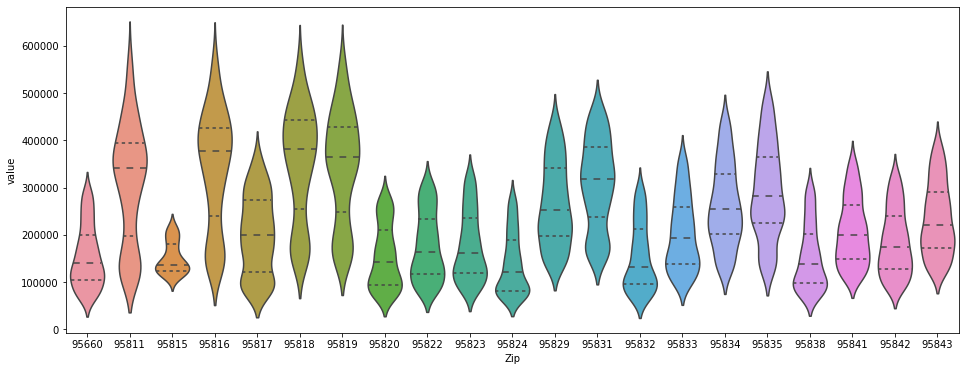

In [68]:
# got figure size  modification example from https://exceptionshub.com/how-do-i-change-the-figure-size-for-a-seaborn-plot.html

# fig, ax = plt.subplots()
# fig.set_size_inches(16, 6)
# sns.violinplot(x="Zip", y="value", data=df_44, scale="count", inner="stick", ax=ax)

import seaborn as sns

data = df_metro.loc[df_metro['City'] == 'Sacramento']

fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
sns.violinplot(x="Zip", y="value", data = df_metro[df_metro['City'] == 'Sacramento'], scale="width", inner="quartile", ax=ax)


In [70]:
df_sac_city_1996_1999 = data.loc['1996-04-01':'1999-12-01']
df_sac_city_1996_1999.tail()

Metro     MetroState  CountyName        City    Zip  \
time                                                                   
1999-08-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95843   
1999-09-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95843   
1999-10-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95843   
1999-11-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95843   
1999-12-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95843   

            SizeRank     value  
time                            
1999-08-01      2123  146400.0  
1999-09-01      2123  147600.0  
1999-10-01      2123  149000.0  
1999-11-01      2123  150300.0  
1999-12-01      2123  151800.0

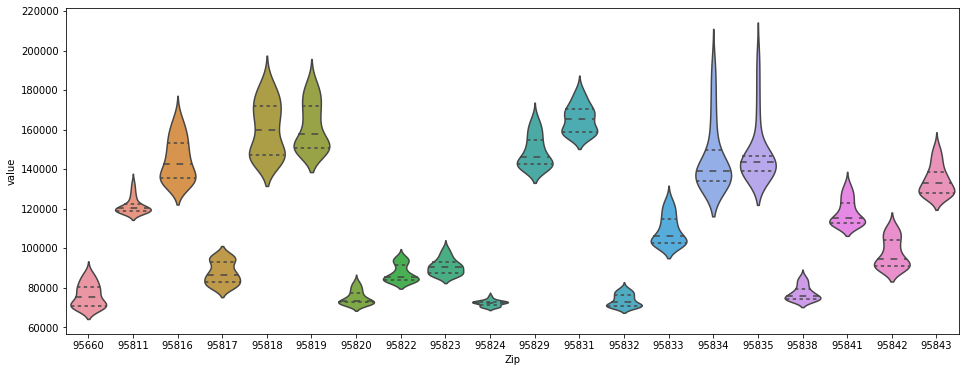

In [71]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
sns.violinplot(x="Zip", y="value", data=df_sac_city_1996_1999, scale="width", inner="quartile", ax=ax)

In [73]:
df_sac_city_2000_2003 = data.loc['2000-01-01':'2003-12-01']
df_sac_city_2000_2003.head()

Metro     MetroState  CountyName        City    Zip  \
time                                                                   
2000-01-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95660   
2000-02-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95660   
2000-03-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95660   
2000-04-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95660   
2000-05-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95660   

            SizeRank    value  
time                           
2000-01-01      3515  89100.0  
2000-02-01      3515  90100.0  
2000-03-01      3515  91200.0  
2000-04-01      3515  92200.0  
2000-05-01      3515  93300.0

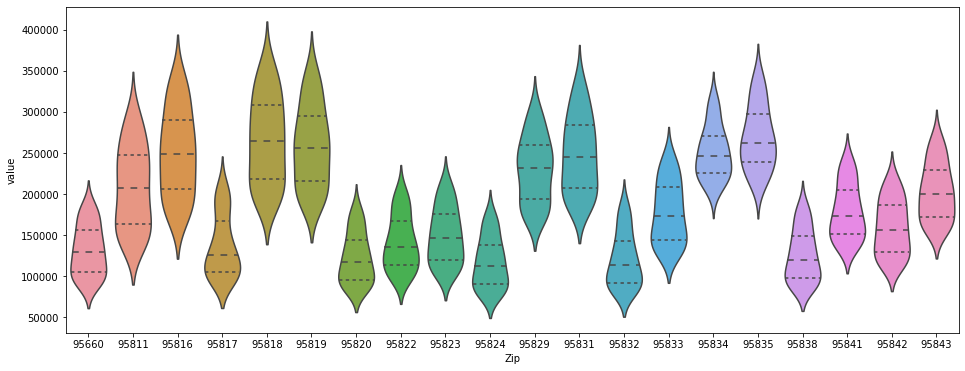

In [74]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
sns.violinplot(x="Zip", y="value", data=df_sac_city_2000_2003, scale="width", inner="quartile", ax=ax)

In [75]:
df_sac_city_2004_2006 = data.loc['2004-01-01':'2006-12-01']
df_sac_city_2004_2006.head()

Metro     MetroState  CountyName        City    Zip  \
time                                                                   
2004-01-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95660   
2004-02-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95660   
2004-03-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95660   
2004-04-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95660   
2004-05-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95660   

            SizeRank     value  
time                            
2004-01-01      3515  191900.0  
2004-02-01      3515  195700.0  
2004-03-01      3515  200200.0  
2004-04-01      3515  205300.0  
2004-05-01      3515  211100.0

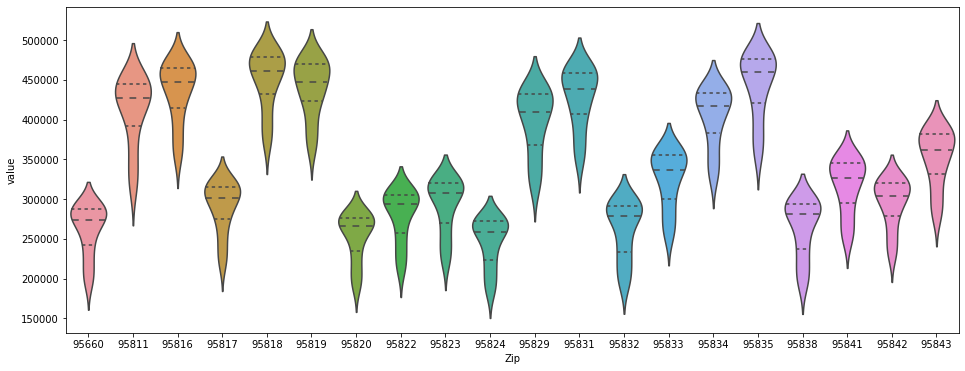

In [76]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
sns.violinplot(x="Zip", y="value", data=df_sac_city_2004_2006, scale="width", inner="quartile", ax=ax)

In [77]:
df_sac_city_2007_2012 = data.loc['2007-01-01':'2012-12-01']
df_sac_city_2007_2012.head()

Metro     MetroState  CountyName        City    Zip  \
time                                                                   
2007-01-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95660   
2007-02-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95660   
2007-03-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95660   
2007-04-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95660   
2007-05-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95660   

            SizeRank     value  
time                            
2007-01-01      3515  264800.0  
2007-02-01      3515  263000.0  
2007-03-01      3515  261000.0  
2007-04-01      3515  258400.0  
2007-05-01      3515  254800.0

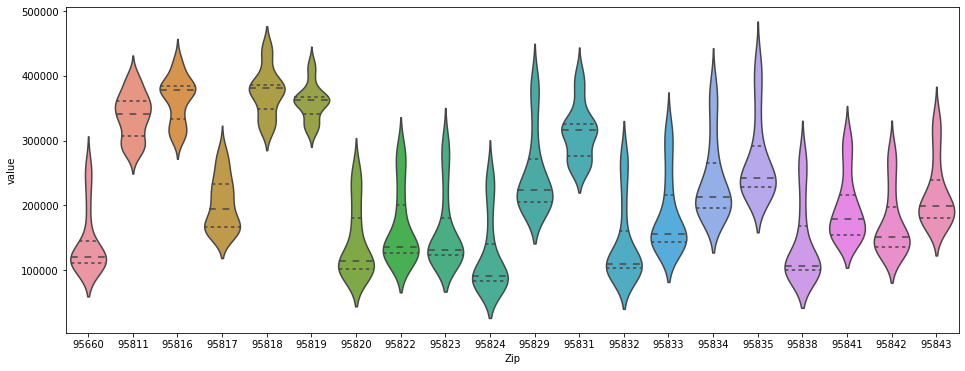

In [78]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
sns.violinplot(x="Zip", y="value", data=df_sac_city_2007_2012, scale="width", inner="quartile", ax=ax)

In [79]:
df_sac_city_2013_2018 = data.loc['2013-01-01':'2018']
df_sac_city_2013_2018.tail()

Metro     MetroState  CountyName        City    Zip  \
time                                                                   
2017-12-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95843   
2018-01-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95843   
2018-02-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95843   
2018-03-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95843   
2018-04-01  Sacramento  Sacramento CA  Sacramento  Sacramento  95843   

            SizeRank     value  
time                            
2017-12-01      2123  345600.0  
2018-01-01      2123  350100.0  
2018-02-01      2123  352500.0  
2018-03-01      2123  352400.0  
2018-04-01      2123  351400.0

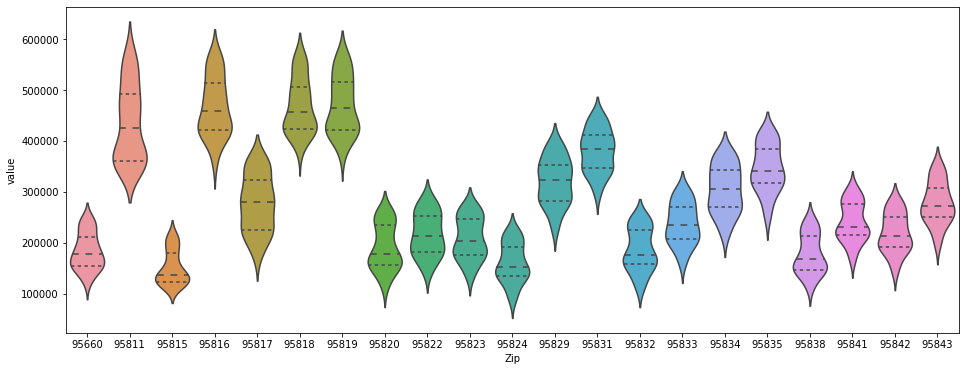

In [80]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
sns.violinplot(x="Zip", y="value", data=df_sac_city_2013_2018, scale="width", inner="quartile", ax=ax)

# Step 4:  Parameter tuning

## Setting up functions for running ARIMA models

In [81]:
import warnings
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


## Creating p, d, q, and m values for running ARIMA model

In [82]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")


## Parameter fine-tuning function

In [83]:
# add each order tuple and mse to lists to create a table of the results

# order_tuples = []
# mse_results = []

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

def eval_params_and_lists(dataset, p_values, d_values, q_values):
    order_tuples = []
    mse_results = []
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    order_tuples.append(order)
                    mse_results.append(mse)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return order_tuples, mse_results, best_cfg, best_score   # adding to Jeff's function; output will be taken into forecast function that follows



In [84]:
# Original function from Jeff's Mod4 project starter notebook 

import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg, best_score   # adding to Jeff's function; output will be taken into forecast function that follows


# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
# evaluate_models(df_kc_melt.values, p_values, d_values, q_values)

# Step 5: ARIMA modeling -- model fit, forecasting, and interpreting results

## Elements of ARIMA model fit, forecast, and summary


### Create ARIMA model and show summary results table

In [85]:
# Define function

def arima_zipcode(ts, order):
    ts_value = ts.value
    model = ARIMA(ts_value, order)
    model_fit = model.fit(disp=0)
    print(model_fit.summary())
    return model_fit

# model_fit = arima_zipcode(ts_values, order = order)

### Create forecast model

In [86]:
# Define function

def forecast(model_fit, months=24, confint=2):
    forecast = model_fit.forecast(months)
    actual_forecast = forecast[0]
    std_error = forecast[1]
    forecast_confint = forecast[confint]
    return actual_forecast, std_error, forecast_confint   

# actual_forecast, std_error, forecast_confint = forecast(model_fit)

### Create dataframe to hold these values and join to existing dataframe

In [87]:
# Define function

def forecast_df(actual_forecast, forecast_confint, std_error, col = 'time', 
                daterange = pd.date_range(start='2018-05-01', end='2020-04-01', freq='MS')):
    df_forecast = pd.DataFrame({col: daterange})
    df_forecast['forecast'] = actual_forecast
    df_forecast['forecast_lower'] = forecast_confint[:, 0]
    df_forecast['forecast_upper'] = forecast_confint[:, 1]
    df_forecast['standard error'] = std_error
    df_forecast.set_index('time', inplace=True)
    return df_forecast


### Create df_new with historical and forecasted values

In [88]:
def concat_values_forecast(ts, df_forecast):
    df_new = pd.concat([ts, df_forecast])
    df_new = df_new.rename(columns = {0: 'value'})
    return df_new

### Plot forecast results

In [89]:
def plot_forecast(df_new, geog_area, figsize=(12,8), fontsize1=14, fontsize2=18):
    fig = plt.figure(figsize=figsize)
    plt.plot(df_new['value'], label='Raw Data')
    plt.plot(df_new['forecast'], label='Forecast')
    plt.fill_between(df_new.index, df_new['forecast_lower'], df_new['forecast_upper'], color='k', alpha = 0.2, 
                 label='Confidence Interval')
    plt.legend(loc = 'upper left', fontsize=fontsize1)
#     plt.xlabel(xlabel='year', fontsize=fontsize1)
#     plt.ylabel(ylabel='value', fontsize=fontsize1)
    plt.tick_params(axis='both', labelsize=fontsize1)
    plt.title(f'Forecast for {geog_area}', fontsize=fontsize2)


### Figure out percent change in home values

In [90]:
def forecast_values(df_new, date = '2020-04-01'):
    forecasted_price = df_new.loc[date, 'forecast']
    forecasted_lower = df_new.loc[date, 'forecast_lower']
    forecasted_upper = df_new.loc[date, 'forecast_upper']    
    return forecasted_price, forecasted_lower, forecasted_upper


### Compute and print predicted, best, and worst case scenarios

In [91]:
def pred_best_worst(pred, low, high, last):
    
    '''Prints out predicted, best-case, and worst-case scencarios from forecast'''
    
    pred_pct_change = (((pred - last) / last) * 100)
    print(f'By the model prediction, I would expect to see a {round(pred_pct_change, 3)}% change in price by April 1, 2020.')
    print(type(pred_pct_change))
    lower_pct_change = (((low - last) / last) * 100)
    print(f'At the lower bound of the confidence interval, I would expect to see a {round(lower_pct_change, 3)}% change in price by April 1, 2020.')
    print(type(lower_pct_change))
    upper_pct_change = (((high - last) / last) * 100)
    print(f'At the upper bound of the confidence interval, I would expect to see a {round(upper_pct_change, 3)}% change in price by April 1, 2020.')
    print(type(upper_pct_change))
    return round(pred_pct_change, 3), round(lower_pct_change, 3), round(upper_pct_change, 3)
        

## Functions to perform ARIMA modeling and display forecast results

In [92]:
# Function to run parameter tuning, ARIMA model, and forecasts.  
# Appends lists set up to capture results for summary table.

p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)

def arima_forecast_run(ts, geog_area, city, county, p_values, d_values, q_values, confint=2):     # months = 24 by default
    
    '''This function attempts to combine the steps of the ARIMA process, starting with parameter fine tuning and
    going all the way through the steps following (ARIMA model fit, forecast, computing percentage changes 
    for each of the forecast values, plotting of historical values and projected values, and printing out 
    the forecasted results.  
    It also appends the lists set up to capture each model's output for a summary dataframe table.'''

    # evaluate parameters
    print(f'For {geog_area} ({city}):')
    p_values = [0, 1, 2, 4, 6, 8, 10]
    d_values = range(0, 3)
    q_values = range(0, 3)
    warnings.filterwarnings("ignore")
    
    order_tuples, mse_results, best_cfg, best_score = eval_params_and_lists(ts.value, p_values, d_values, q_values)     
    order = best_cfg
    
    print(f'Best ARIMA order = {order}')
    model_fit = arima_zipcode(ts, order)                                # returns model_fit
    actual_forecast, forecast_confint, std_error = forecast(model_fit)  # returns actual_forecast, forecast_confint, std_error
    df_forecast = forecast_df(actual_forecast, std_error, forecast_confint, col = 'time',     # returns df_forecast with future predictions
                              daterange = pd.date_range(start='2018-05-01', end='2020-04-01', freq='MS'))
    df_new = concat_values_forecast(ts, df_forecast)                    # concatenates historical and forecasted values into df_new
    plot_forecast(df_new, geog_area)                            # plots forecast with the label of geog_area
    forecasted_price, forecasted_lower, forecasted_upper = forecast_values(df_new, date = '2020-04-01')   # returns forecasted_price, forecasted_lower, forecasted_upper
    pred = forecasted_price
    low = forecasted_lower
    high = forecasted_upper
    last = df_new['value'].loc['2018-04-01']
    pred_pct_change = (((pred - last) / last) * 100)
    lower_pct_change = (((low - last) / last) * 100)
    upper_pct_change = (((high - last) / last) * 100)
       
    geog_areas.append(geog_area)
    cities.append(city)
    counties.append(county)
    orders.append(order)
    predicted_prices.append(round(forecasted_price, 2))
    lower_bound_prices.append(round(forecasted_lower, 2))
    upper_bound_prices.append(round(forecasted_upper, 2))
    last_values.append(last)
    pred_pct_changes.append(round(pred_pct_change, 2))
    lower_pct_changes.append(round(lower_pct_change, 2))
    upper_pct_changes.append(round(upper_pct_change, 2))
    
    print(f'By the model prediction, I would expect to see a {round(pred_pct_change, 3)}% change in price by April 1, 2020.')
    print(f'At the lower bound of the confidence interval, I would expect to see a {round(lower_pct_change, 3)}% change in price by April 1, 2020.')
    print(f'At the upper bound of the confidence interval, I would expect to see a {round(upper_pct_change, 3)}% change in price by April 1, 2020.')

    return order_tuples, mse_results, best_cfg, best_score, geog_areas, cities, counties, orders, predicted_prices, lower_bound_prices, upper_bound_prices, last_values, pred_pct_changes, lower_pct_changes, upper_pct_changes


### ARIMA modeling and forecast function -- don't run parameter optimization

In [93]:
# Function that takes in pdq values and runs ARIMA model and forecasts.
# Appends lists set up to capture results for summary table.

def arima_forecast_enter_pdq(ts, geog_area, city, county, best_cfg, confint=2):     # months = 24 by default
    
    '''This function combines the steps of the ARIMA process, starting with ARIMA model fit, forecast 
    (predicted values, upper-bound values,and lower-bound values, determined by confidence intervals), 
    percentage changes for each of the forecast values over time, final values at the end of the 
    forecast period, plotting of historical values and projected values, and a printout of the forecasted 
    results.  It also appends the lists set up to capture each model's output for a summary dataframe table.'''
    
    # evaluate parameters
    print(f'For {geog_area} ({city}):')

    warnings.filterwarnings("ignore")
    order = best_cfg
    print(f'Best ARIMA order = {order}')
    model_fit = arima_zipcode(ts, order)                                # returns model_fit
    actual_forecast, forecast_confint, std_error = forecast(model_fit)  # returns actual_forecast, forecast_confint, std_error
    df_forecast = forecast_df(actual_forecast, std_error, forecast_confint, col = 'time',     # returns df_forecast with future predictions
                              daterange = pd.date_range(start='2018-05-01', end='2020-04-01', freq='MS'))
    df_new = concat_values_forecast(ts, df_forecast)                    # concatenates historical and forecasted values into df_new
    plot_forecast(df_new, geog_area)                            # plots forecast with the label of geog_area
    forecasted_price, forecasted_lower, forecasted_upper = forecast_values(df_new, date = '2020-04-01')   # returns forecasted_price, forecasted_lower, forecasted_upper
    pred = forecasted_price
    low = forecasted_lower
    high = forecasted_upper
    last = df_new['value'].loc['2018-04-01']
    pred_pct_change = (((pred - last) / last) * 100)
    lower_pct_change = (((low - last) / last) * 100)
    upper_pct_change = (((high - last) / last) * 100)
       
    geog_areas.append(geog_area)
    cities.append(city)
    counties.append(county)
    orders.append(order)
    predicted_prices.append(round(forecasted_price, 2))
    lower_bound_prices.append(round(forecasted_lower, 2))
    upper_bound_prices.append(round(forecasted_upper, 2))
    last_values.append(last)
    pred_pct_changes.append(round(pred_pct_change, 2))
    lower_pct_changes.append(round(lower_pct_change, 2))
    upper_pct_changes.append(round(upper_pct_change, 2))
    
    print(f'By the model prediction, I would expect to see a {round(pred_pct_change, 3)}% change in price by April 1, 2020.')
    print(f'At the lower bound of the confidence interval, I would expect to see a {round(lower_pct_change, 3)}% change in price by April 1, 2020.')
    print(f'At the upper bound of the confidence interval, I would expect to see a {round(upper_pct_change, 3)}% change in price by April 1, 2020.')

    return geog_areas, cities, counties, orders, predicted_prices, lower_bound_prices, upper_bound_prices, last_values, pred_pct_changes, lower_pct_changes, upper_pct_changes


### ARIMA modeling and forecast function -- don't append lists, don't run parameter optimization

In [94]:
# Function that takes in pdq values and runs ARIMA model and forecasts.
# Does NOT append lists set up to capture results for summary table.

def arima_forecast_enter_pdq_no_listappend(ts, geog_area, city, county, best_cfg, confint=2):     # months = 24 by default
    
    '''This function combines the steps of the ARIMA process, starting with ARIMA model fit, forecast 
    (predicted values, upper-bound values,and lower-bound values, determined by confidence intervals), 
    percentage changes for each of the forecast values over time, final values at the end of the 
    forecast period, plotting of historical values and projected values, and a printout of the forecasted 
    results.  
    It does NOT append the lists set up to capture each model's output for a summary dataframe table.  It 
    provides a way to produce ARIMA model output again to check on the model when troubleshooting without
    appending results to the existing lists.'''

    
    # evaluate parameters
    print(f'For {geog_area} ({city}):')

    warnings.filterwarnings("ignore")
    order = best_cfg
    print(f'Best ARIMA order = {order}')
    model_fit = arima_zipcode(ts, order)                                # returns model_fit
    actual_forecast, forecast_confint, std_error = forecast(model_fit)  # returns actual_forecast, forecast_confint, std_error
    df_forecast = forecast_df(actual_forecast, std_error, forecast_confint, col = 'time',     # returns df_forecast with future predictions
                              daterange = pd.date_range(start='2018-05-01', end='2020-04-01', freq='MS'))
    df_new = concat_values_forecast(ts, df_forecast)                    # concatenates historical and forecasted values into df_new
    plot_forecast(df_new, geog_area)                            # plots forecast with the label of geog_area
    forecasted_price, forecasted_lower, forecasted_upper = forecast_values(df_new, date = '2020-04-01')   # returns forecasted_price, forecasted_lower, forecasted_upper
    pred = forecasted_price
    low = forecasted_lower
    high = forecasted_upper
    last = df_new['value'].loc['2018-04-01']
    pred_pct_change = (((pred - last) / last) * 100)
    lower_pct_change = (((low - last) / last) * 100)
    upper_pct_change = (((high - last) / last) * 100)
       
#     geog_areas.append(geog_area)
#     cities.append(city)
#     counties.append(county)
#     orders.append(order)
#     predicted_prices.append(round(forecasted_price, 2))
#     lower_bound_prices.append(round(forecasted_lower, 2))
#     upper_bound_prices.append(round(forecasted_upper, 2))
#     last_values.append(last)
#     pred_pct_changes.append(round(pred_pct_change, 2))
#     lower_pct_changes.append(round(lower_pct_change, 2))
#     upper_pct_changes.append(round(upper_pct_change, 2))
    
    print(f'By the model prediction, I would expect to see a {round(pred_pct_change, 3)}% change in price by April 1, 2020.')
    print(f'At the lower bound of the confidence interval, I would expect to see a {round(lower_pct_change, 3)}% change in price by April 1, 2020.')
    print(f'At the upper bound of the confidence interval, I would expect to see a {round(upper_pct_change, 3)}% change in price by April 1, 2020.')

#     return geog_areas, cities, counties, orders, predicted_prices, lower_bound_prices, upper_bound_prices, last_values, pred_pct_changes, lower_pct_changes, upper_pct_changes


### ARIMA modeling and forecast function -- on/off switch for parameter fine-tuning

In [95]:
# Function to run parameter tuning, ARIMA model, and forecasts.  Features on/off switch for running parameter tuning (pdq).
# Unfortunately, this one throws an error when I set run_pdq=True

p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)

def arima_forecast(ts, geog_area, city, county, p_values, d_values, q_values, best_pdq, confint=2, run_pdq = False):     # months = 24 by default
    
    '''This function attempts to combine the steps of the ARIMA process, starting with parameter fine tuning and
    going all the way through the steps following (ARIMA model fit, forecast, computing percentage changes 
    for each of the forecast values, plotting of historical values and projected values, and printing out 
    the forecasted results.  
    It also appends the lists set up to capture each model's output for a summary dataframe table.
    (Unforunately, this function throws an error if run_pdq is set = True.)'''

    
    # evaluate parameters
    print(f'For {geog_area} ({city}):')
    p_values = [0, 1, 2, 4, 6, 8, 10]
    d_values = range(0, 3)
    q_values = range(0, 3)
    warnings.filterwarnings("ignore")
    
    if run_pdq:
        best_cfg, best_score = eval_arima_models(ts, p_values, d_values, q_values)     # returns order (variable best_cfg)
        order = best_cfg
    else:
        order = best_pdq
        
    print(f'Best ARIMA order = {order}')
    model_fit = arima_zipcode(ts, order)                                # returns model_fit
    actual_forecast, forecast_confint, std_error = forecast(model_fit)  # returns actual_forecast, forecast_confint, std_error
    df_forecast = forecast_df(actual_forecast, std_error, forecast_confint, col = 'time',     # returns df_forecast with future predictions
                              daterange = pd.date_range(start='2018-05-01', end='2020-04-01', freq='MS'))
    df_new = concat_values_forecast(ts, df_forecast)                    # concatenates historical and forecasted values into df_new
    plot_forecast(df_new, geog_area)                            # plots forecast with the label of geog_area
    forecasted_price, forecasted_lower, forecasted_upper = forecast_values(df_new, date = '2020-04-01')   # returns forecasted_price, forecasted_lower, forecasted_upper
    pred = forecasted_price
    low = forecasted_lower
    high = forecasted_upper
    last = df_new['value'].loc['2018-04-01']
    pred_pct_change = (((pred - last) / last) * 100)
    lower_pct_change = (((low - last) / last) * 100)
    upper_pct_change = (((high - last) / last) * 100)
       
    geog_areas.append(geog_area)
    cities.append(city)
    counties.append(county)
    orders.append(order)
    predicted_prices.append(round(forecasted_price, 2))
    lower_bound_prices.append(round(forecasted_lower, 2))
    upper_bound_prices.append(round(forecasted_upper, 2))
    last_values.append(last)
    pred_pct_changes.append(round(pred_pct_change, 2))
    lower_pct_changes.append(round(lower_pct_change, 2))
    upper_pct_changes.append(round(upper_pct_change, 2))
    
    print(f'By the model prediction, I would expect to see a {round(pred_pct_change, 3)}% change in price by April 1, 2020.')
    print(f'At the lower bound of the confidence interval, I would expect to see a {round(lower_pct_change, 3)}% change in price by April 1, 2020.')
    print(f'At the upper bound of the confidence interval, I would expect to see a {round(upper_pct_change, 3)}% change in price by April 1, 2020.')

    return geog_areas, cities, counties, orders, predicted_prices, lower_bound_prices, upper_bound_prices, last_values, pred_pct_changes, lower_pct_changes, upper_pct_changes


## Functions to store and show results


### Function to create empty lists for storing results

In [1033]:
#  Create empty lists to hold results (called by next function)

# geog_areas = []
# cities = []
# counties = []
# orders = []
# predicted_prices = []
# lower_bound_prices = [] 
# upper_bound_prices = []
# last_values = []
# pred_pct_changes = []
# lower_pct_changes = []
# upper_pct_changes = []


In [503]:
# def create_empty_lists():
#     geog_areas = []
#     cities = []
#     counties = []
#     orders = []
#     predicted_prices = []
#     lower_bound_prices = [] 
#     upper_bound_prices = []
#     last_values = []
#     pred_pct_changes = []
#     lower_pct_changes = []
#     upper_pct_changes = []
#     return geog_areas, cities, counties, orders, predicted_prices, lower_bound_prices, upper_bound_prices, last_values, pred_pct_changes, lower_pct_changes, upper_pct_changes


# create_empty_lists()                # only run this command if you want to empty all lists

# geog_areas, cities, orders, predicted_prices, lower_bound_prices, upper_bound_prices, last_values, pred_pct_changes, lower_pct_changes, upper_pct_changes = create_empty_lists()
# geog_areas, cities, orders, predicted_prices, lower_bound_prices, upper_bound_prices, last_values, pred_pct_changes, lower_pct_changes, upper_pct_changes

([], [], [], [], [], [], [], [], [], [], [])

### Function to print results lists

In [504]:
#  prints all results lists as they currently stand

# def print_results_lists():
#     return geog_areas, cities, counties, orders, predicted_prices, lower_bound_prices, upper_bound_prices, last_values, pred_pct_changes, lower_pct_changes, upper_pct_changes


In [505]:
# print_results_lists()

([], [], [], [], [], [], [], [], [], [], [])

### Function to pop last item off of each list (to remove last item if an analysis was done in error)

In [506]:
# def pop_results_lists():
#     geog_areas.pop()
#     cities.pop()
#     counties.pop()
#     orders.pop()
#     predicted_prices.pop()
#     lower_bound_prices.pop() 
#     upper_bound_prices.pop()
#     last_values.pop()
#     pred_pct_changes.pop()
#     lower_pct_changes.pop()
#     upper_pct_changes.pop()
#     return geog_areas, cities, counties, orders, predicted_prices, lower_bound_prices, upper_bound_prices, last_values, pred_pct_changes, lower_pct_changes, upper_pct_changes


In [507]:
# pop_results_lists()

### Function to print length of each list (to make sure they're all the same length)

In [508]:
# def print_lengths():
#     print('geog_areas: ', len(geog_areas))
#     print('cities: ', len(cities))
#     print('counties', len(counties))
#     print('orders: ', len(orders))
#     print('predicted_prices: ', len(predicted_prices))
#     print('lower_bound_prices: ', len(lower_bound_prices))
#     print('upper_bound_prices: ', len(upper_bound_prices))
#     print('last_values: ', len(last_values))
#     print('pred_pct_changes: ', len(pred_pct_changes))
#     print('lower_pct_changes: ', len(lower_pct_changes))
#     print('upper_pct_changes: ', len(upper_pct_changes))
    

In [96]:
# print_lengths()

# Quick EDA of top US metro areas 

## Plotting top 30 metro areas

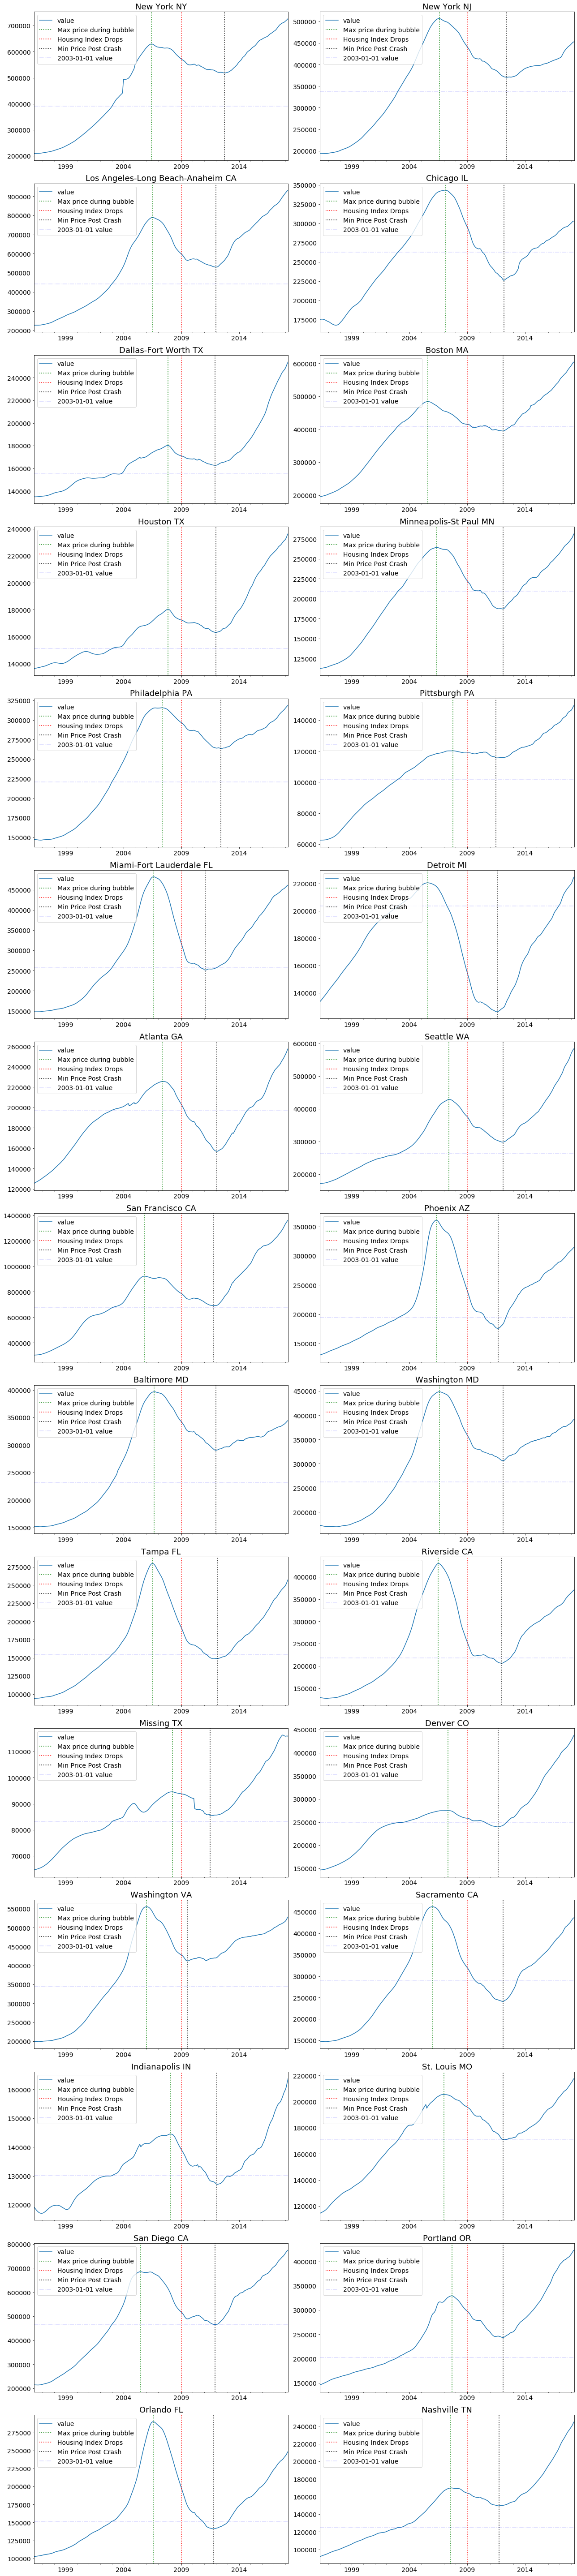

In [1341]:
# Plotting top 30 metros; no standardized y-axis

fig, ax = plot_ts_metros(df_metro_values, large_metro_list_30, figsize = (18, 80), nrows = 15, 
                         ncols = 2, set_ylim = False, fontsize1=14, fontsize2=18)

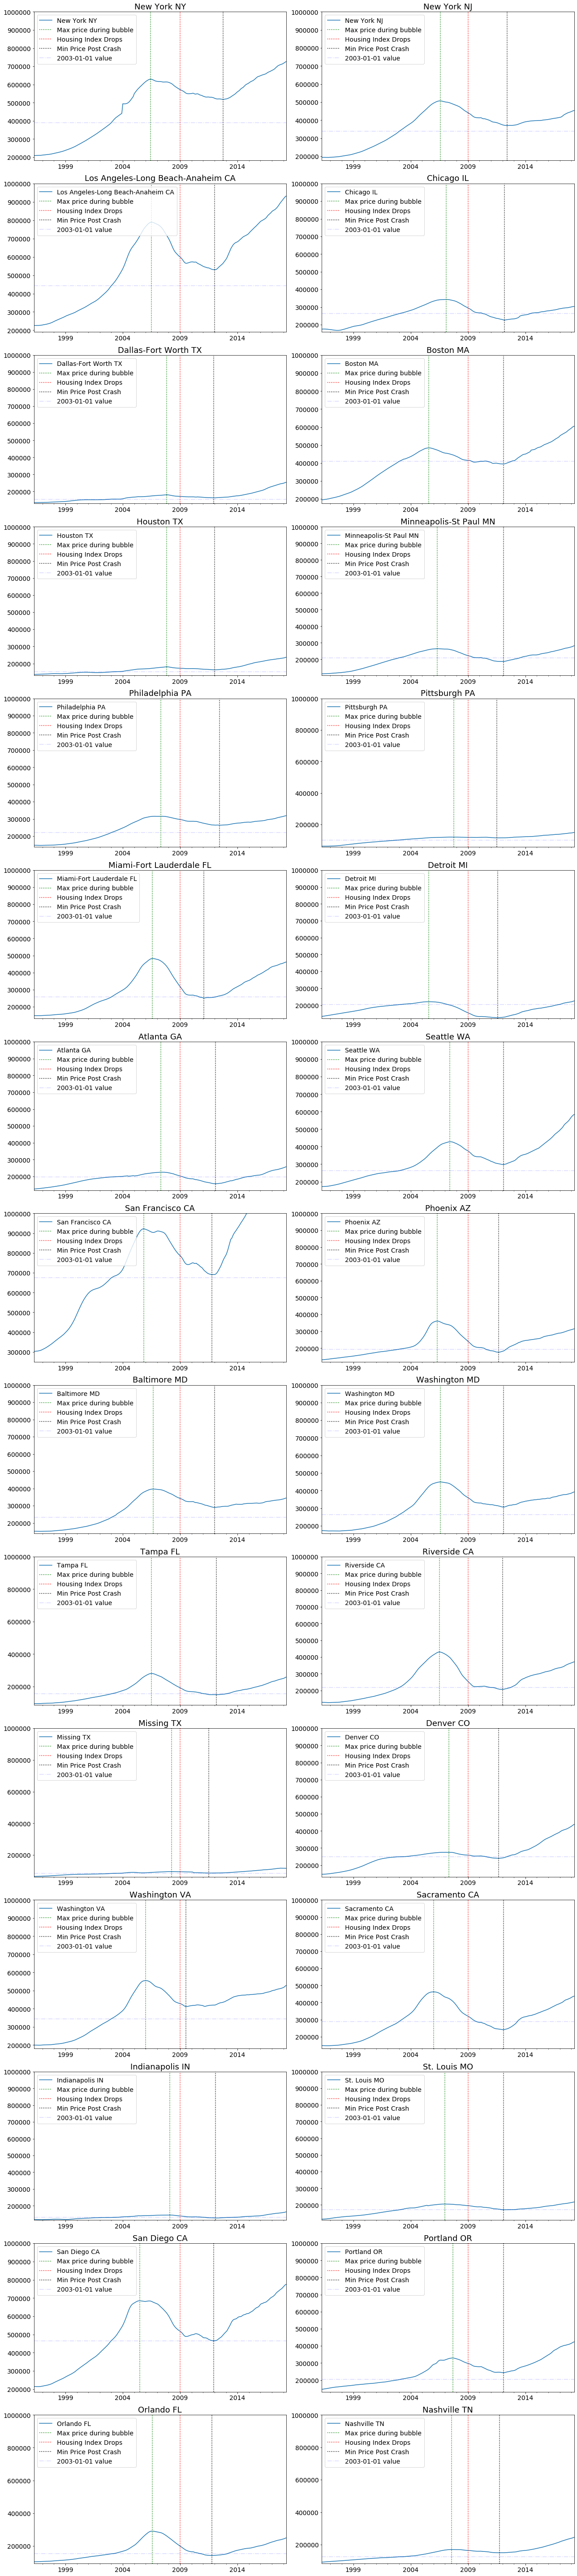

In [1356]:
# Plotting top 30 metros; standardized y-axis

fig, ax = plot_ts_metros(df_metro_values, large_metro_list_30, figsize = (18, 80), nrows = 15, ncols = 2, set_ylim = True, ylim = 1000000)  

## Plotting top metro areas 6 at a time (for use in presentation)

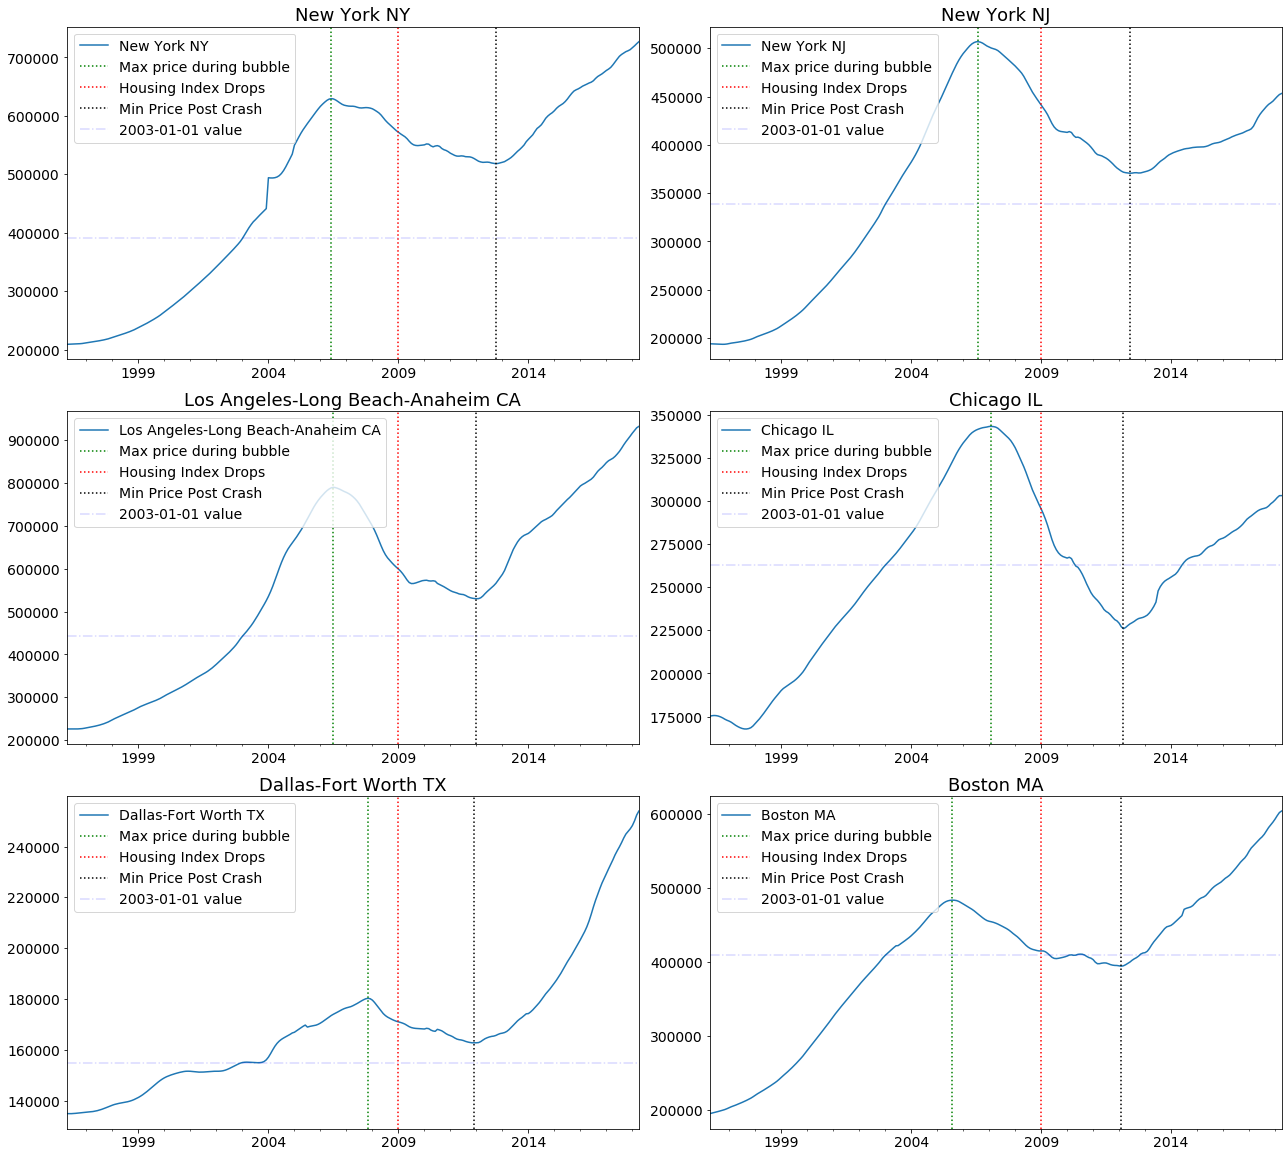

In [1415]:
fig, ax = plot_ts_metros(df_metro_values, large_metro_list_30[0:6], figsize=(18, 80), nrows=3, ncols=2, set_ylim = False, ylim = 1000000);


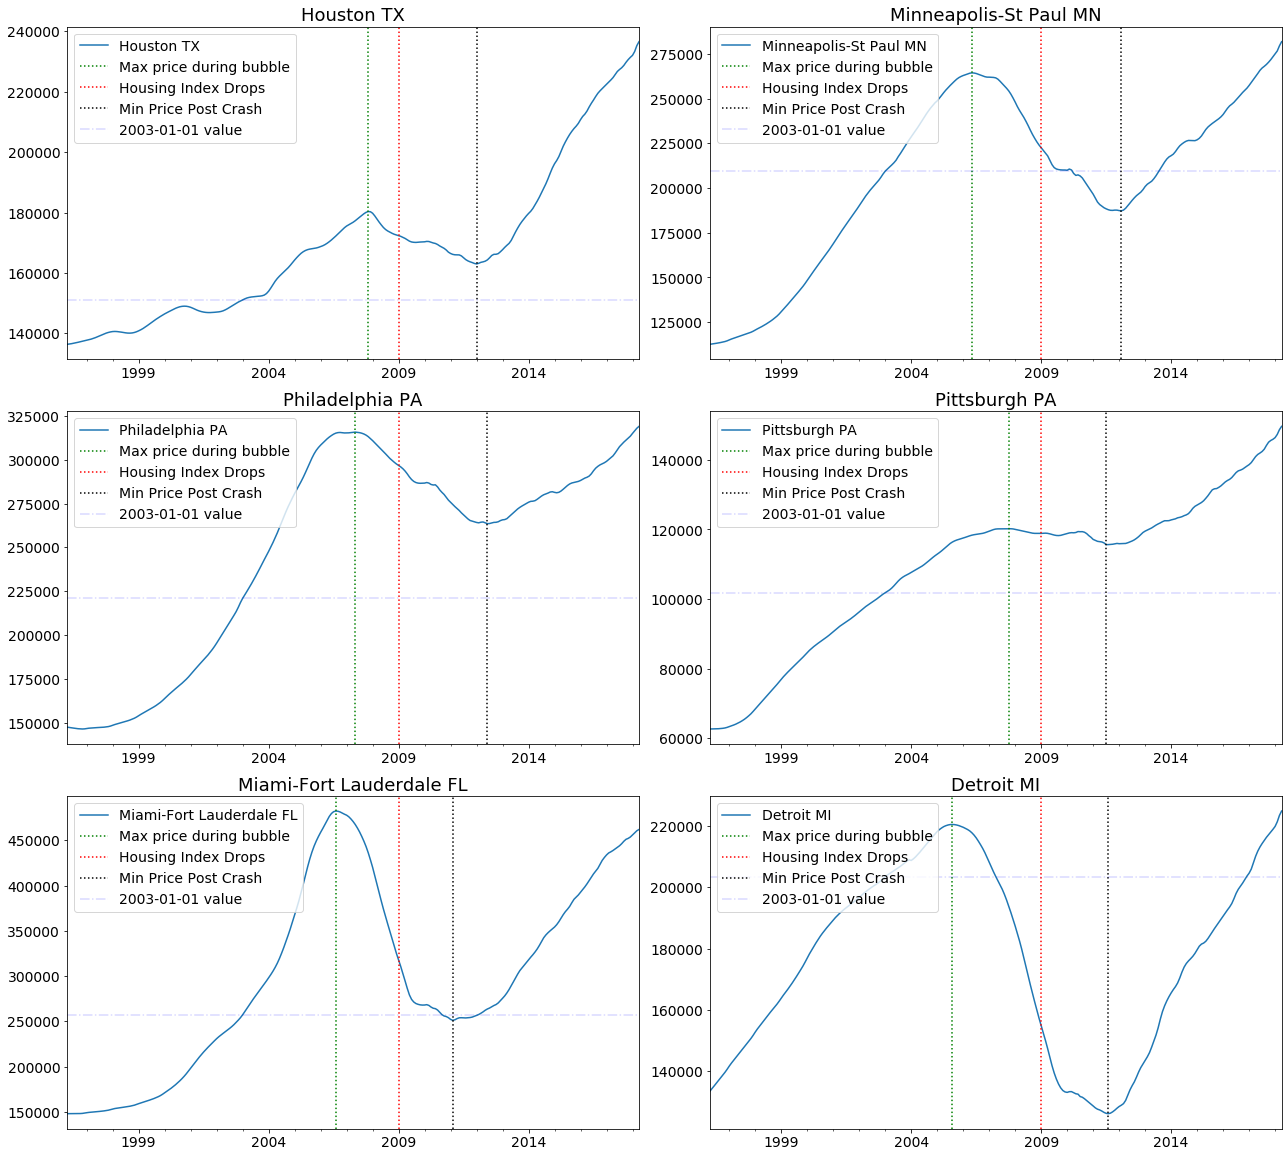

In [1416]:
fig, ax = plot_ts_metros(df_metro_values, large_metro_list_30[6:12], figsize=(18, 80), nrows=3, ncols=2, set_ylim = False, ylim = 1000000);


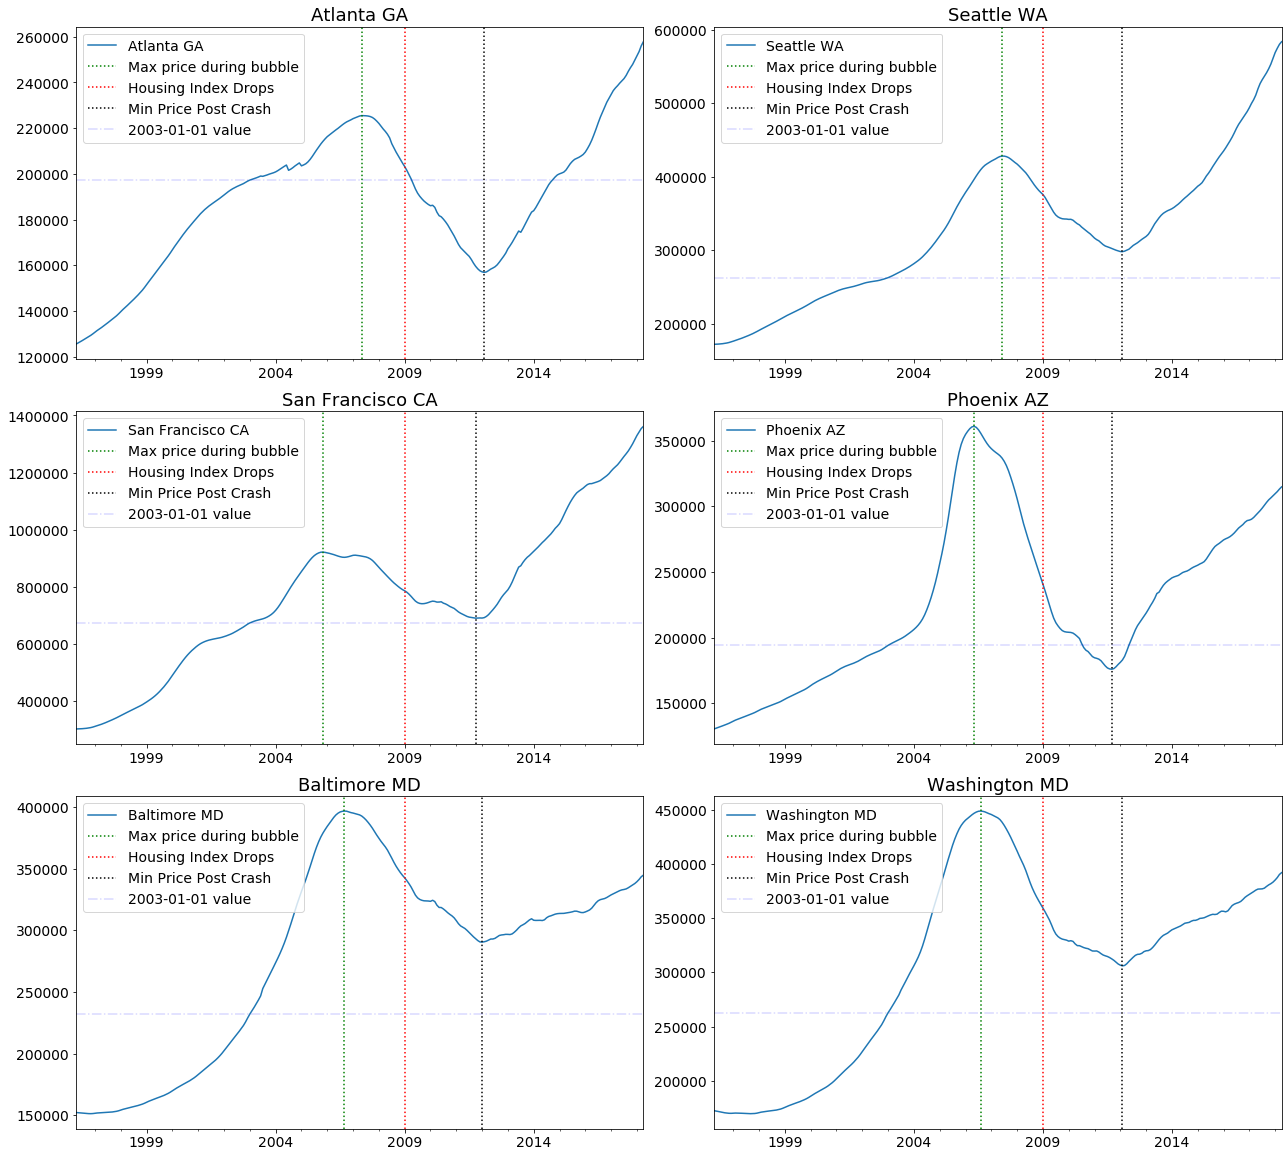

In [1417]:
fig, ax = plot_ts_metros(df_metro_values, large_metro_list_30[12:18], figsize=(18, 80), nrows=3, ncols=2, set_ylim = False, ylim = 1000000);


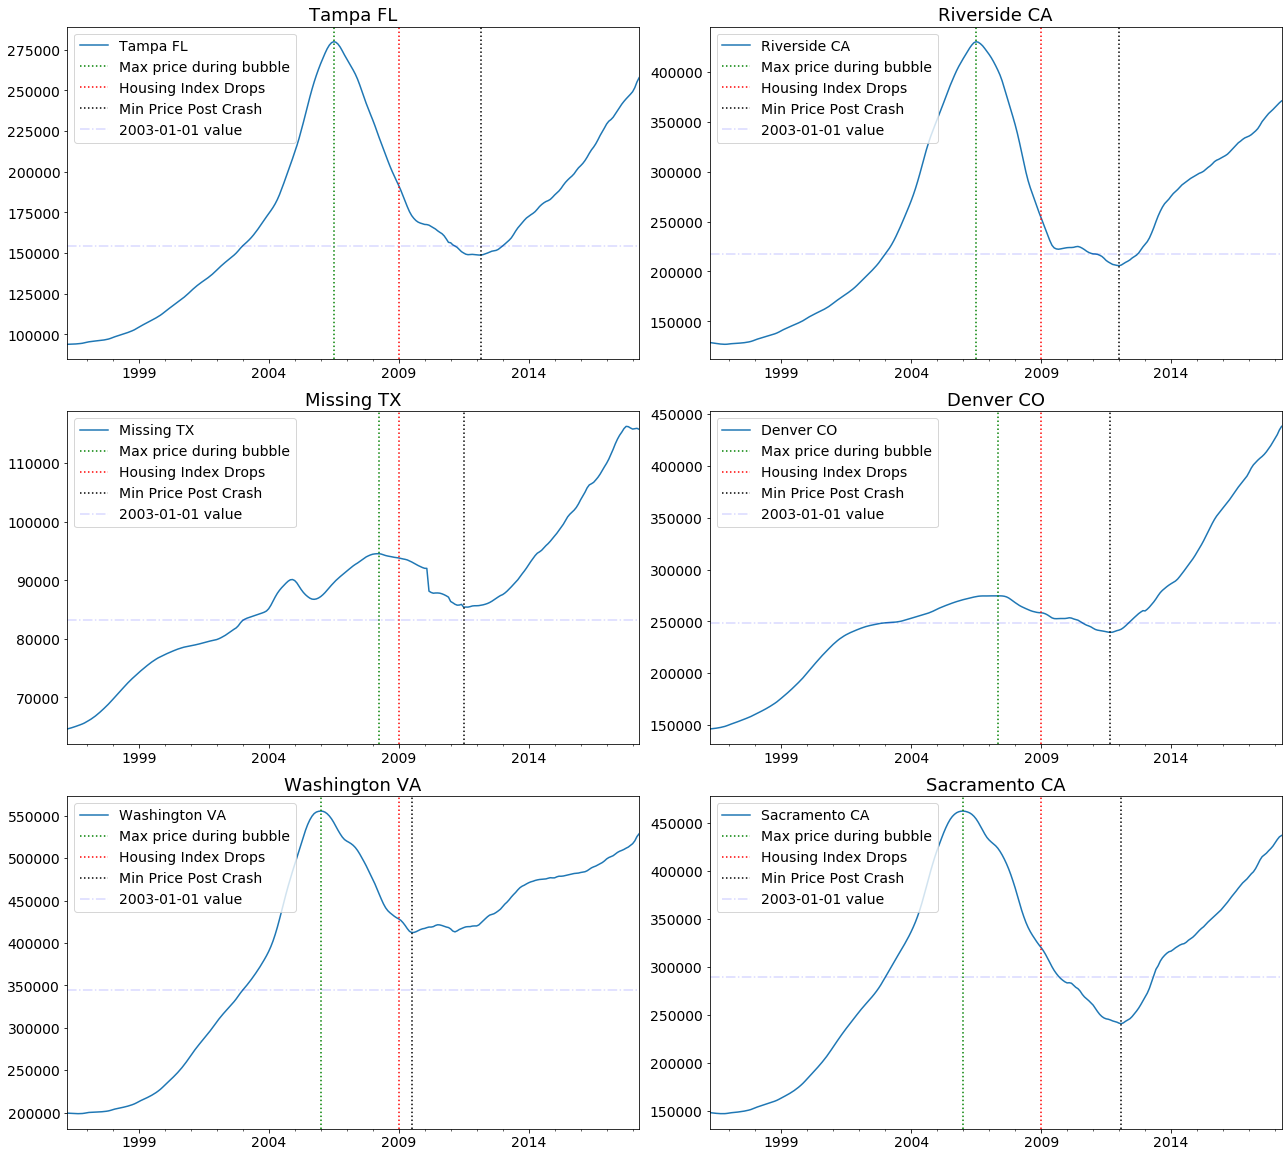

In [1418]:
fig, ax = plot_ts_metros(df_metro_values, large_metro_list_30[18:24], figsize=(18, 80), nrows=3, ncols=2, set_ylim = False, ylim = 1000000);


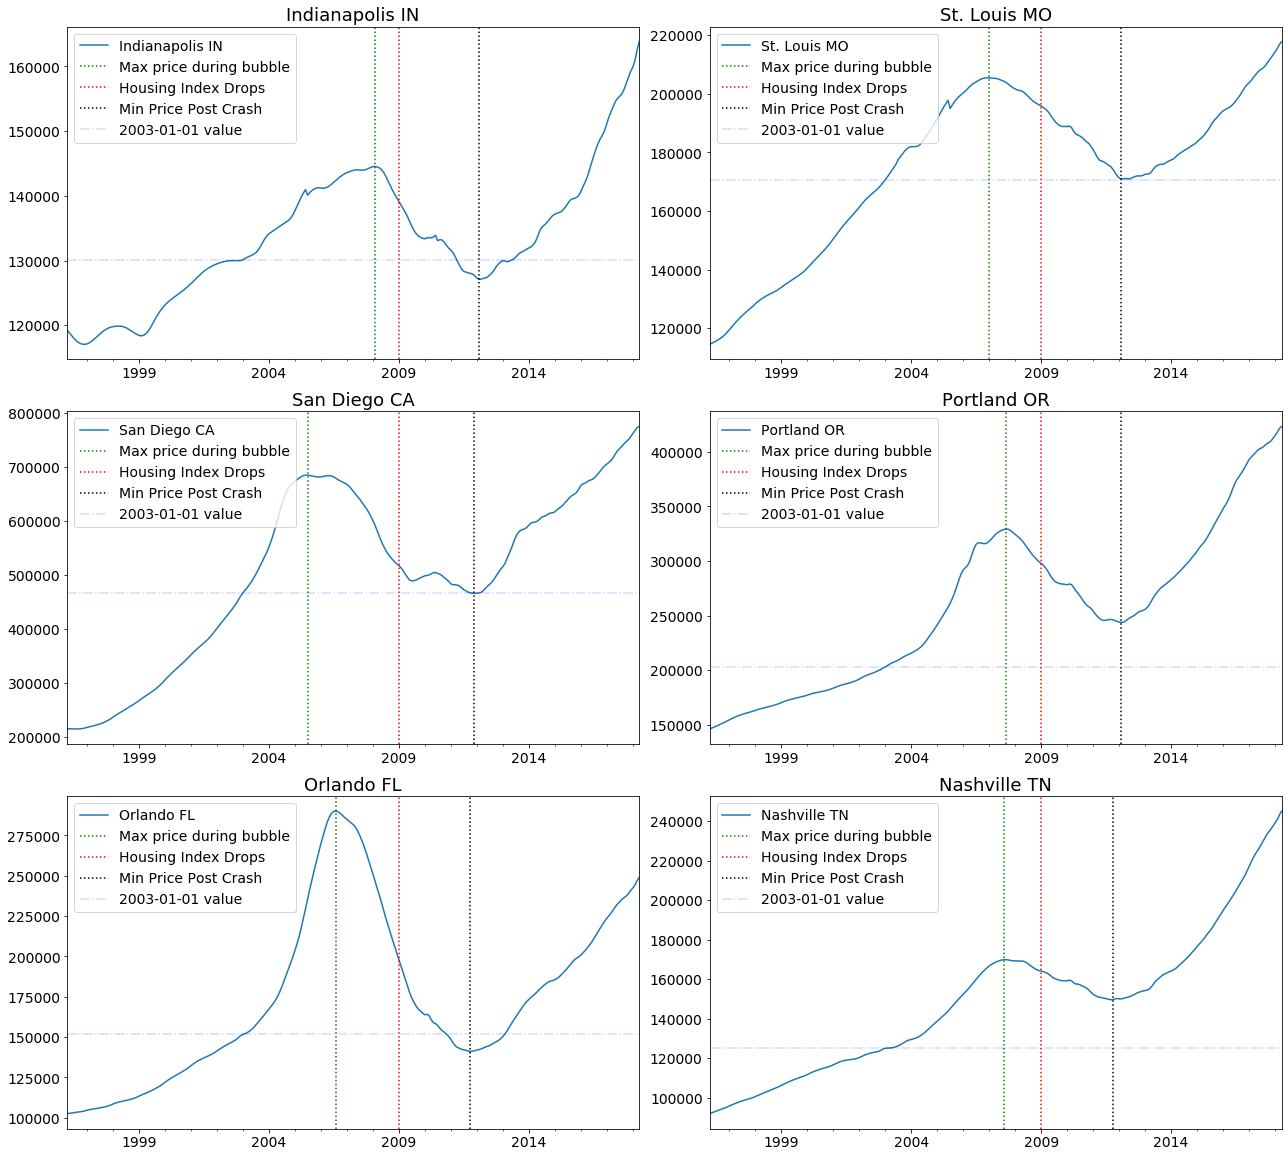

In [1419]:
fig, ax = plot_ts_metros(df_metro_values, large_metro_list_30[24:30], figsize=(18, 80), nrows=3, ncols=2, set_ylim = False, ylim = 1000000);


# Investment modeling:  Dallas-Fort Worth TX Metro Area 

Summary/conclusion:  Metro area presents potentially strong investment opportunities

### Create ts dataframe for *single* geographic area

In [1367]:
geog_area = 'Dallas-Fort Worth TX'

In [1437]:
ts_dallas = df_geog(df=df_metro_cities, col = 'MetroState', geog = 'Dallas-Fort Worth TX')
ts_dallas.head()

Metro            MetroState CountyName   City  \
time                                                                    
1996-04-01  Dallas-Fort Worth  Dallas-Fort Worth TX     Collin  Allen   
1996-05-01  Dallas-Fort Worth  Dallas-Fort Worth TX     Collin  Allen   
1996-06-01  Dallas-Fort Worth  Dallas-Fort Worth TX     Collin  Allen   
1996-07-01  Dallas-Fort Worth  Dallas-Fort Worth TX     Collin  Allen   
1996-08-01  Dallas-Fort Worth  Dallas-Fort Worth TX     Collin  Allen   

            SizeRank     value  
time                            
1996-04-01    1021.5  235850.0  
1996-05-01    1021.5  233050.0  
1996-06-01    1021.5  230450.0  
1996-07-01    1021.5  228100.0  
1996-08-01    1021.5  226050.0

In [1438]:
ts_dallas.tail()

Metro            MetroState CountyName      City  \
time                                                                       
2017-12-01  Dallas-Fort Worth  Dallas-Fort Worth TX       Wise  Paradise   
2018-01-01  Dallas-Fort Worth  Dallas-Fort Worth TX       Wise  Paradise   
2018-02-01  Dallas-Fort Worth  Dallas-Fort Worth TX       Wise  Paradise   
2018-03-01  Dallas-Fort Worth  Dallas-Fort Worth TX       Wise  Paradise   
2018-04-01  Dallas-Fort Worth  Dallas-Fort Worth TX       Wise  Paradise   

            SizeRank     value  
time                            
2017-12-01   10531.0  228700.0  
2018-01-01   10531.0  231300.0  
2018-02-01   10531.0  233900.0  
2018-03-01   10531.0  236900.0  
2018-04-01   10531.0  239800.0

In [1370]:
ts_dallas_values = ts_dallas.value

In [1439]:
ts_dallas_values.head()

time
1996-04-01    134910.628019
1996-05-01    134892.270531
1996-06-01    134899.033816
1996-07-01    134945.410628
1996-08-01    135023.671498
Name: value, dtype: float64

### Visualizations

#### Plot of Dallas-Fort Worth TX metro area

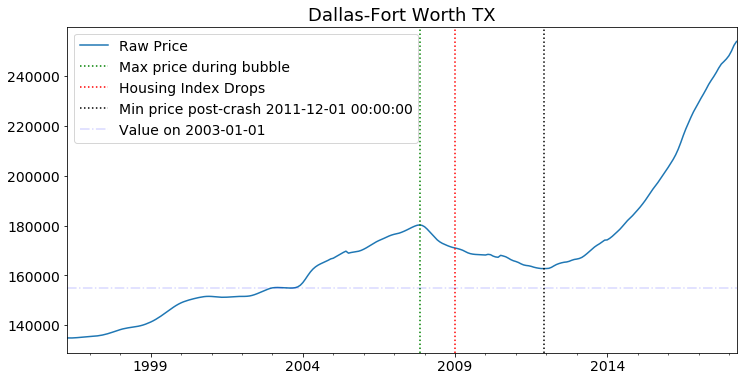

In [1365]:
plot_single_geog(df_metro_values, 'Dallas-Fort Worth TX', col1 = 'value', col2 = 'MetroState', 
                figsize=(12, 6), fontsize1=14, fontsize2=18)

#### Plot ACF and PACF for ts dataframe

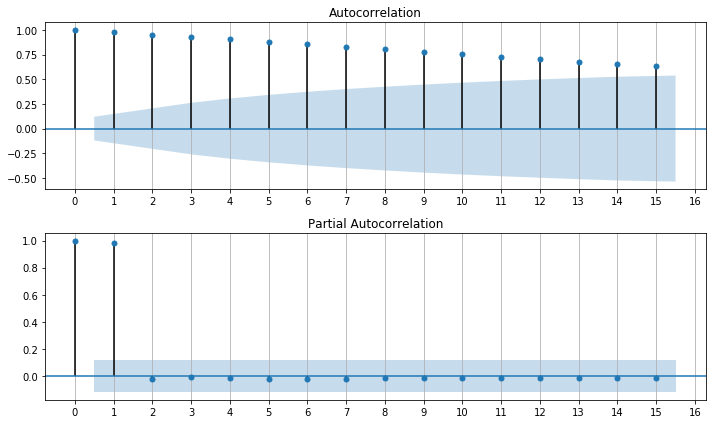

In [1372]:
plot_acf_pacf(ts_dallas_values, figsize=(10,6), lags=15)

#### Plot seasonal decomposition for ts dataframe

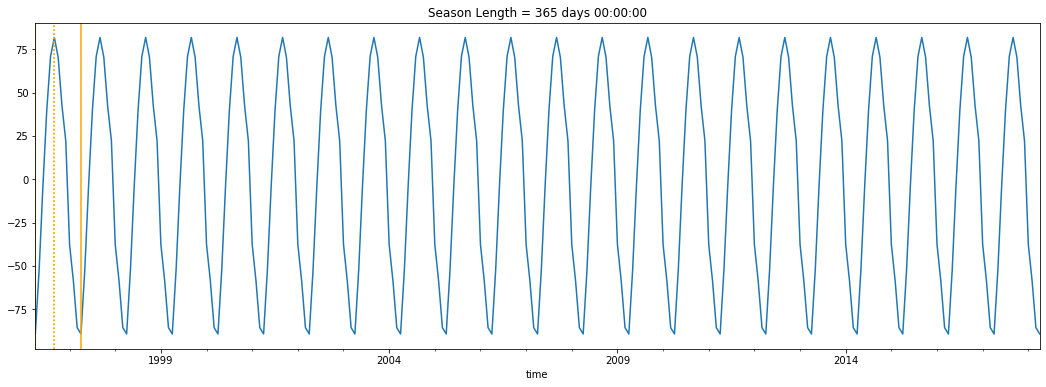

In [1375]:
plot_seasonal_decomp(ts_dallas_values);

# Seasonality is not a significant factor affecting house prices in this geography

### ARIMA parameter tuning, modeling, and forecasting

In [1376]:
p_values = [0, 1, 2, 4, 6, 8]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

In [1377]:
# eval_arima_models(ts, p_values, d_values, q_values)  # don't run this until you have some time, since it take time
# note that ts must only contain values and time as index

# eval_arima_models(ts_dallas_values, p_values, d_values, q_values)  # don't run this until you have some time, since it take time

#### Generate model fit summary

In [1379]:
# model_fit = arima_zipcode(ts, order = None)   # change order = tuple to correspond to the best MSE produced by previous function

model_fit_dallas = arima_zipcode(ts_dallas, order = (8,2,0))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  263
Model:                 ARIMA(8, 2, 0)   Log Likelihood               -1766.841
Method:                       css-mle   S.D. of innovations            199.998
Date:                Thu, 26 Mar 2020   AIC                           3553.681
Time:                        15:07:45   BIC                           3589.403
Sample:                    06-01-1996   HQIC                          3568.037
                         - 04-01-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.0269      8.260      0.730      0.466     -10.162      22.215
ar.L1.D2.value    -0.0313      0.062     -0.502      0.616      -0.154       0.091
ar.L2.D2.value    -0.0190      0.062

#### Produce forecasts from ARIMA model fit

In [1380]:
def forecast(model_fit, months=24, confint=2):
    forecast = model_fit.forecast(months)
    actual_forecast = forecast[0]
    std_error = forecast[1]
    forecast_confint = forecast[confint]
    return actual_forecast, std_error, forecast_confint   

# actual_forecast, std_error, forecast_confint = forecast(model_fit, months=24, confint=2)


In [1381]:
actual_forecast, std_error, forecast_confint = forecast(model_fit_dallas)

In [1382]:
actual_forecast, std_error, forecast_confint

(array([255459.51738605, 257053.86403676, 258797.10361023, 260540.81158621,
        262155.35438135, 263602.40861049, 265108.07880797, 266763.96349418,
        268439.62597247, 270085.76722291, 271697.70456765, 273330.73239422,
        275022.60475627, 276744.28974742, 278439.73712736, 280110.28505618,
        281786.70217403, 283484.26834723, 285196.56731211, 286905.13514835,
        288605.93825565, 290312.88963415, 292036.71251424, 293773.14548958]),
 array([  199.99751345,   441.60909567,   732.0505511 ,  1050.29928213,
         1392.46580023,  1761.02641072,  2156.7902079 ,  2562.05387495,
         2964.30622594,  3369.23906752,  3782.49555034,  4208.78311702,
         4648.56331939,  5100.58015662,  5565.77305879,  6047.20786932,
         6545.78239805,  7059.97024985,  7587.84152529,  8128.16743243,
         8680.79808209,  9245.64055973,  9821.95853243, 10408.89859176]),
 array([[255067.52946268, 255851.50530942],
        [256188.326114  , 257919.40195952],
        [257362.3108

#### Create dataframe to hold forecast results

In [1384]:
# df_forecast = forecast_df(col = 'time', daterange = pd.date_range(start='2018-05-01', end='2020-04-01', freq='MS'), 
#                 actual_forecast=actual_forecast, forecast_confint = forecast_confint)

df_forecast = forecast_df(col = 'time', daterange = pd.date_range(start='2018-05-01', end='2020-04-01', freq='MS'), 
                actual_forecast=actual_forecast, std_error = std_error, forecast_confint = forecast_confint)

#### Create new dataframe concatenating historic values and forecast results

In [1385]:
# df_new = concat_values_forecast(ts, df_forecast)

df_new = concat_values_forecast(ts_dallas_values, df_forecast)

In [1386]:
df_new

value       forecast  forecast_lower  forecast_upper  \
time                                                                       
1996-04-01  134910.628019            NaN             NaN             NaN   
1996-05-01  134892.270531            NaN             NaN             NaN   
1996-06-01  134899.033816            NaN             NaN             NaN   
1996-07-01  134945.410628            NaN             NaN             NaN   
1996-08-01  135023.671498            NaN             NaN             NaN   
1996-09-01  135120.289855            NaN             NaN             NaN   
1996-10-01  135233.333333            NaN             NaN             NaN   
1996-11-01  135334.299517            NaN             NaN             NaN   
1996-12-01  135422.705314            NaN             NaN             NaN   
1997-01-01  135492.753623            NaN             NaN             NaN   
1997-02-01  135564.734300            NaN             NaN             NaN   
1997-03-01  135635.265700            NaN             NaN             NaN   
1997-04-01  135733.816425            NaN             NaN             NaN   
1997-05-01  135882.608696            NaN             NaN             NaN   
1997-06-01  136071.980676            NaN             NaN             NaN   
1997-07-01  136308.695652            NaN             NaN             NaN   
1997-08-01  136579.710145            NaN             NaN             NaN   
1997-09-01  136887.922705            NaN             NaN             NaN   
1997-10-01  137222.222222            NaN             NaN             NaN   
1997-11-01  137567.149758            NaN             NaN             NaN   
1997-12-01  137914.009662            NaN             NaN             NaN   
1998-01-01  138238.164251            NaN             NaN             NaN   
1998-02-01  138525.120773            NaN             NaN             NaN   
1998-03-01  138755.072464            NaN             NaN             NaN   
1998-04-01  138941.545894            NaN             NaN             NaN   
1998-05-01  139097.101449            NaN             NaN             NaN   
1998-06-01  139246.859903            NaN             NaN             NaN   
1998-07-01  139401.932367            NaN             NaN             NaN   
1998-08-01  139585.024155            NaN             NaN             NaN   
1998-09-01  139814.009662            NaN             NaN             NaN   
1998-10-01  140093.719807            NaN             NaN             NaN   
1998-11-01  140441.062802            NaN             NaN             NaN   
1998-12-01  140839.613527            NaN             NaN             NaN   
1999-01-01  141285.024155            NaN             NaN             NaN   
1999-02-01  141789.855072            NaN             NaN             NaN   
1999-03-01  142353.623188            NaN             NaN             NaN   
1999-04-01  142973.429952            NaN             NaN             NaN   
1999-05-01  143644.927536            NaN             NaN             NaN   
1999-06-01  144366.183575            NaN             NaN             NaN   
1999-07-01  145100.000000            NaN             NaN             NaN   
1999-08-01  145841.062802            NaN             NaN             NaN   
1999-09-01  146560.869565            NaN             NaN             NaN   
1999-10-01  147254.589372            NaN             NaN             NaN   
1999-11-01  147910.144928            NaN             NaN             NaN   
1999-12-01  148498.067633            NaN             NaN             NaN   
2000-01-01  149005.314010            NaN             NaN             NaN   
2000-02-01  149431.400966            NaN             NaN             NaN   
2000-03-01  149789.371981            NaN             NaN             NaN   
2000-04-01  150108.212560            NaN             NaN             NaN   
2000-05-01  150391.304348            NaN             NaN             NaN   
2000-06-01  150657.004831            NaN             NaN            

#### Calculate predicted, lower bound, and upper bound forecasted prices

In [1387]:
forecasted_price, forecasted_lower, forecasted_upper = forecast_values(df_new)

In [1388]:
forecasted_price, forecasted_lower, forecasted_upper  # predicted, best-case, and worst-case prices in 2020

(293773.14548958297, 273372.07913100213, 314174.2118481638)

In [1389]:
last_value = df_new['value'].loc['2018-04-01']

In [1390]:
last_value

253947.46543778802

#### Plot forecast with confidence intervals

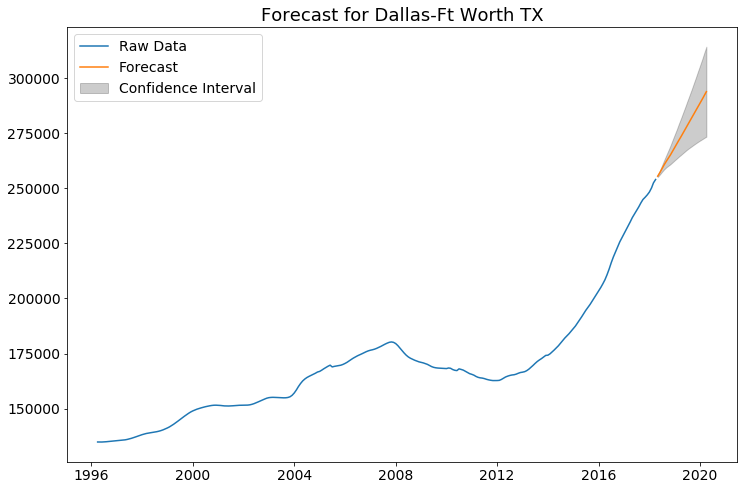

In [1394]:
# plot_forecast(df_new, figsize=(12,8), geog=None)

plot_forecast(df_new, figsize=(12,8), geog_area='Dallas-Ft Worth TX')

#### Print summary of predicted, worst-case, and best-case scenarios

In [1396]:
# def pred_best_worst(pred, low, high, last, date='April 1, 2020'):
#     pred_pct_change = (((pred - last) / last) * 100)
#     print(f'By the model prediction, I would expect to see a {round(pred_pct_change, 3)}% change in price by April 1, 2020')
#     lower_pct_change = ((low - last) / last) * 100
#     print(f'At the lower bound of the confidence interval, I would expect to see a {round(lower_pct_change, 3)}% change in price by April 1, 2020')
#     upper_pct_change = ((high - last) / last) * 100
#     print(f'At the upper bound of the confidence interval, I would expect to see a {round(upper_pct_change, 3)}% change in price by April 1, 2020')
        

pred_best_worst(pred=forecasted_price, low=forecasted_lower, high=forecasted_upper, last=last_value)

By the model prediction, I would expect to see a 15.683% change in price by April 1, 2020.
<class 'numpy.float64'>
At the lower bound of the confidence interval, I would expect to see a 7.649% change in price by April 1, 2020.
<class 'numpy.float64'>
At the upper bound of the confidence interval, I would expect to see a 23.716% change in price by April 1, 2020.
<class 'numpy.float64'>


(15.683, 7.649, 23.716)

### ARIMA modeling results:  predictions and visualization

#### ARIMA forecast function for metro area -- don't run parameter optimization

In [1402]:
# Function that takes in pdq values and runs ARIMA model and forecasts.
# Appends lists set up to capture results for summary table.

def arima_forecast_metro_enter_pdq(ts, geog_area, best_cfg, confint=2):     # months = 24 by default
    
    '''This function combines the steps of the ARIMA process, starting with ARIMA model fit, forecast 
    (predicted values, upper-bound values,and lower-bound values, determined by confidence intervals), 
    percentage changes for each of the forecast values over time, final values at the end of the 
    forecast period, plotting of historical values and projected values, and a printout of the forecasted 
    results.  It also appends the lists set up to capture each model's output for a summary dataframe table.'''
    
    # evaluate parameters
    print(f'For {geog_area}:')

    warnings.filterwarnings("ignore")
    order = best_cfg
    print(f'Best ARIMA order = {order}')
    model_fit = arima_zipcode(ts, order)                                # returns model_fit
    actual_forecast, forecast_confint, std_error = forecast(model_fit)  # returns actual_forecast, forecast_confint, std_error
    df_forecast = forecast_df(actual_forecast, std_error, forecast_confint, col = 'time',     # returns df_forecast with future predictions
                              daterange = pd.date_range(start='2018-05-01', end='2020-04-01', freq='MS'))
    df_new = concat_values_forecast(ts, df_forecast)                    # concatenates historical and forecasted values into df_new
    plot_forecast(df_new, geog_area)                            # plots forecast with the label of geog_area
    forecasted_price, forecasted_lower, forecasted_upper = forecast_values(df_new, date = '2020-04-01')   # returns forecasted_price, forecasted_lower, forecasted_upper
    pred = forecasted_price
    low = forecasted_lower
    high = forecasted_upper
    last = df_new['value'].loc['2018-04-01']
    pred_pct_change = (((pred - last) / last) * 100)
    lower_pct_change = (((low - last) / last) * 100)
    upper_pct_change = (((high - last) / last) * 100)
       
    met_geog_areas.append(geog_area)
    met_orders.append(order)
    met_predicted_prices.append(round(forecasted_price, 2))
    met_lower_bound_prices.append(round(forecasted_lower, 2))
    met_upper_bound_prices.append(round(forecasted_upper, 2))
    met_last_values.append(last)
    met_pred_pct_changes.append(round(pred_pct_change, 2))
    met_lower_pct_changes.append(round(lower_pct_change, 2))
    met_upper_pct_changes.append(round(upper_pct_change, 2))
    
    print(f'By the model prediction, I would expect to see a {round(pred_pct_change, 3)}% change in price by April 1, 2020.')
    print(f'At the lower bound of the confidence interval, I would expect to see a {round(lower_pct_change, 3)}% change in price by April 1, 2020.')
    print(f'At the upper bound of the confidence interval, I would expect to see a {round(upper_pct_change, 3)}% change in price by April 1, 2020.')

    return met_geog_areas, met_orders, met_predicted_prices, met_lower_bound_prices, met_upper_bound_prices, met_last_values, met_pred_pct_changes, met_lower_pct_changes, met_upper_pct_changes


In [1403]:
#  Create empty lists to hold results (called by next function)

met_geog_areas = []
met_orders = []
met_predicted_prices = []
met_lower_bound_prices = [] 
met_upper_bound_prices = []
met_last_values = []
met_pred_pct_changes = []
met_lower_pct_changes = []
met_upper_pct_changes = []


#### Run ARIMA function for Dallas-Ft Worth region

For Dallas-Ft Worth TX:
Best ARIMA order = (8, 2, 0)
                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  263
Model:                 ARIMA(8, 2, 0)   Log Likelihood               -1766.841
Method:                       css-mle   S.D. of innovations            199.998
Date:                Thu, 26 Mar 2020   AIC                           3553.681
Time:                        15:20:15   BIC                           3589.403
Sample:                    06-01-1996   HQIC                          3568.037
                         - 04-01-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.0269      8.260      0.730      0.466     -10.162      22.215
ar.L1.D2.value    -0.0313      0.062     -0.502      0.616      -0

(['Dallas-Ft Worth TX'],
 [(8, 2, 0)],
 [293773.15],
 [273372.08],
 [314174.21],
 [253947.46543778802],
 [15.68],
 [7.65],
 [23.72])

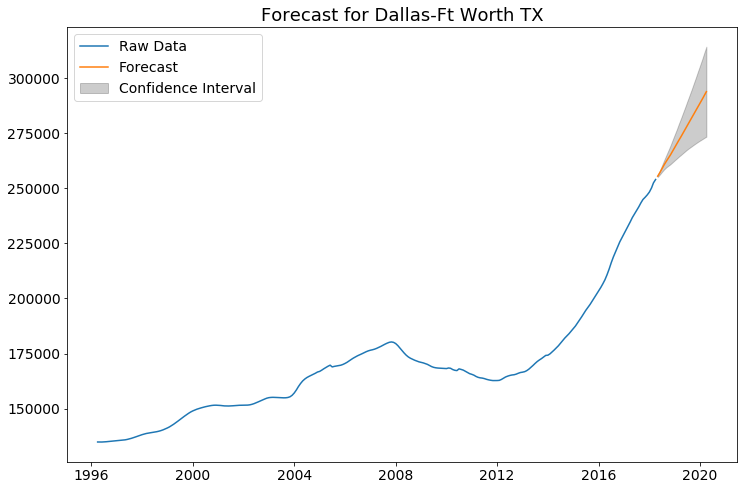

In [1404]:
arima_forecast_metro_enter_pdq(ts_dallas, geog_area='Dallas-Ft Worth TX', best_cfg = (8,2,0), confint=2)


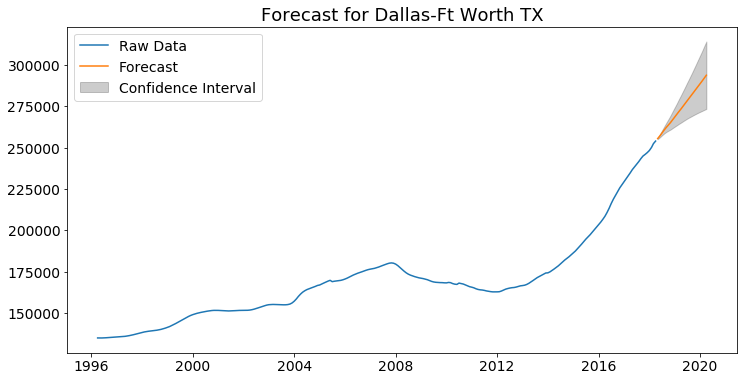

In [1420]:
plot_forecast(df_new, geog_area='Dallas-Ft Worth TX', figsize=(12,6), fontsize1=14, fontsize2=18)

### Dallas-Ft Worth TX:  Excellent investment opportunity

By the model prediction, I would expect to see a 15.683% change in price by April 1, 2020.
At the lower bound of the confidence interval, I would expect to see a 7.649% change in price by April 1, 2020.
At the upper bound of the confidence interval, I would expect to see a 23.716% change in price by April 1, 2020.

## Plotting values by zip code, grouped by city or within a city

### Plotting values by city

### Plots of zip codes within cities

### Plotting cities and zip codes within metro area 

### Plotting cities 6 at a time (for use in presentation)

### Plotting boxplots by city in metro region

### Plotting boxplots by ZIP in metro region

### Plotting boxplots by ZIPs in a city

# Notebook spacer


# Notebook spacer


# Notebook spacer
